# 1. Perkenalan


GC 6

Nama            : Muhammad Fiqih Al-ayubi

Batch           : HCK-17

Phase           : 1

Objective       :

Program ini dibuat untuk membuat model machine learning yang dapat melakukan clustering nasabah kartu kredit



Gambaran Dataset :

Data yang digunakan adalah data nasabah pemegang kartu kredit. Data ini merupakan data informasi penggunaan kartu kredit selama 6 bulan terakhir.

### 1.2. Deskripsi kolom

CUST_ID                             : Id customer

BALANCE                             : Jumlah uang yang dapat dipakai setelah melakukan transaksi

BALANCE_FREQUENCY                   : Rasio yang menggambarkan seberapa sering nilai balance berubah

PURCHASES                           : Jumlah transaksi yang menggunakan kartu kredit. Nilainya merupakan penjumlahan antara one off purchase dan installments purchase

ONEOFF_PURCHASES                    : Nilai transaksi dengan metode pelunasan di awal

INSTALLMENTS_PURCHASES              : Nilai transaksi dengan metode cicilan (contoh menyicil mobil atau rumah)

CASH_ADVANCE                        : Uang tunai yang dapat didapatkan menggunakan kartu kredit

PURCHASES_FREQUENCY                 : Rasio yang menggambarkan seberapa sering transaksi dengan kartu kredit (kecuali cash advance) dilakukan

ONEOFFPURCHASESFREQUENCY            : Rasio yang menggambarkan seberapa sering transaksi dengan metode pelunasan awal dilakukan

PURCHASESINSTALLMENTSFREQUENCY      : Rasio yang menggambarkan seberapa sering transaksi dengan metode cicilan dilakukan

CASHADVANCEFREQUENCY                : Rasio yang menggambarkan seberapa sering transaksi cash advance dilakukan

CASHADVANCETRX                      : Jumlah transaksi yang dilakukan dengan metode cash advance

PURCHASES_TRX                       : Jumlah transaksi yang dilakukan dengan kartu kredit (installments purchase, one off purchase, atau keduanya)

CREDIT_LIMIT                        : Limit saldo yang dapat digunakan untuk melakukan transaksi menggunakan kartu rkedit

PAYMENTS                            : Jumlah uang yang sudah dibayarkan nasabah untuk melunasi tagihan

MINIMUM_PAYMENTS                    : Jumlah uang minimal yang harus dibayar nasabah agar tidak masuk kategori gagal bayar

PRCFULLPAYMENT                      : Jumlah uang yang telah dibayar nasabah per total tagihan

TENURE                              : Lama waktu cicilan atau pelunasan tagihan

# 2. Query SQL

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "fine-advantage-424306-i2" 
client = bigquery.Client(project=project_id)

df = client.query('''
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_msib_hck.credit-card-information`
WHERE MOD(CUST_ID, 2) != 1
''').to_dataframe()


# 3. Import libraries

In [48]:
# Import tools dasar
import pandas as pd
import numpy as np
from scipy import stats

# Library Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import plotly.express as px

# Library outliers handling
from feature_engine.outliers import Winsorizer

# Library scaling 
from sklearn.preprocessing import RobustScaler

# Import model clustering
from sklearn.cluster import KMeans

# Library Model Evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


# Save Model
import pickle
import joblib
import json

# Library matriks regresi linear
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Libbrary untuk cross validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Library untuk tuning hyperparameter
from sklearn.model_selection import GridSearchCV

# Library untuk melakukan dimensional reduction
from sklearn.decomposition import PCA

# Library untuk mencari nilai K optimal
from yellowbrick.cluster import KElbowVisualizer



# 4. Data loading

In [49]:
# Membuat dataframe
df = pd.read_csv('credit-card.csv').sort_values(by='CUST_ID')

# Atur maximum display kolom
pd.set_option('display.max_columns', None)

In [50]:
# Melihat 10 baris pertama
df.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
3137        1  1854.033230           1.000000    1013.50            576.00   
1751        3   129.836526           0.909091    1433.99            743.99   
1496        5    21.580264           0.909091     284.72              0.00   
8           7    16.379412           0.454545     178.15              0.00   
3164        9   686.657879           1.000000    2476.45           1624.50   
4055       11    89.708187           1.000000    1808.60           1808.60   
3252       13  2931.237524           1.000000     150.00            150.00   
111        15  5429.372649           1.000000     493.10              0.00   
1497       17  1381.080028           1.000000     360.00              0.00   
333        19   237.344299           1.000000    1266.03            170.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
3137                  437.50   1243.093189             0.500000   
1751                  690.00      0.000000             0.909091   
1496                  284.72      0.000000             0.666667   
8                     178.15      0.000000             0.250000   
3164                  851.95    253.273353             1.000000   
4055                    0.00    450.417925             0.916667   
3252                    0.00   1434.135353             0.083333   
111                   493.10      0.000000             0.500000   
1497                  360.00      0.000000             0.666667   
333                  1096.03      0.000000             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
3137                    0.083333                          0.333333   
1751                    0.454545                          0.636364   
1496                    0.000000                          0.666667   
8                       0.000000                          0.250000   
3164                    0.750000                          1.000000   
4055                    0.916667                          0.000000   
3252                    0.083333                          0.000000   
111                     0.000000                          0.500000   
1497                    0.000000                          0.666667   
333                     0.083333                          1.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
3137                0.083333                 5             15        2000.0   
1751                0.000000                 0             19        4000.0   
1496                0.000000                 0             16        5000.0   
8                   0.000000                 0              3        5000.0   
3164                0.083333                 1             35        4000.0   
4055                0.166667                 3             26        7500.0   
3252                0.083333                 3              3        3000.0   
111                 0.000000                 0              6       12000.0   
1497                0.000000                 0              8        1000.0   
333                 0.000000                 0             46        1800.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
3137   654.473825       1524.375697          0.000000      12  
1751  1363.134203        141.648860          0.875000      11  
1496   344.161416        155.792859          0.800000      12  
8      229.376368         89.613822          0.181818      12  
3164  1600.734366        224.265608          0.083333      12  
4055  1890.186096        139.117341          0.444444      12  
3252   577.725789       1683.482088          0.000000      12  
111   1415.589572       1440.327788          0.000000      12  
1497   115.649241      13564.391210          0.000000      12  
333    729.118157        189.433393          0.500000      12

In [51]:
1013.5 + 1243.093 - 654.47

1602.1229999999998

In [52]:
# Melihat 10 baris terakhir
df.tail(10)

CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
3122     8931    837.631184           1.000000       0.00              0.00   
1129     8933    125.793836           1.000000     630.00              0.00   
1130     8935      0.000000           0.000000     102.72              0.00   
1131     8937    108.889031           1.000000    1145.85            445.85   
2290     8939    106.894095           0.909091      62.73              0.00   
1132     8941  10571.411070           1.000000    7739.48              0.00   
2466     8943   2584.317807           1.000000       0.00              0.00   
1486     8945    655.712971           1.000000     264.35            202.80   
4429     8947   6593.820644           1.000000     388.66            388.66   
4103     8949     37.307085           0.833333     363.38              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
3122                    0.00    867.928181             0.000000   
1129                  630.00      0.000000             1.000000   
1130                  102.72      0.000000             1.000000   
1131                  700.00      0.000000             1.000000   
2290                   62.73      0.000000             0.272727   
1132                 7739.48      0.000000             1.000000   
2466                    0.00   6036.492283             0.000000   
1486                   61.55      0.000000             0.333333   
4429                    0.00   4621.934580             0.583333   
4103                  363.38     36.363896             0.833333   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
3122                    0.000000                          0.000000   
1129                    0.000000                          0.916667   
1130                    0.000000                          1.000000   
1131                    0.916667                          0.750000   
2290                    0.000000                          0.181818   
1132                    0.000000                          1.000000   
2466                    0.000000                          0.000000   
1486                    0.083333                          0.166667   
4429                    0.583333                          0.000000   
4103                    0.000000                          0.666667   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
3122                0.083333                 1              0        1000.0   
1129                0.000000                 0             12        1000.0   
1130                0.000000                 0             12        1500.0   
1131                0.000000                 0             22        5000.0   
2290                0.000000                 0              3        5000.0   
1132                0.000000                 0             44        8000.0   
2466                0.250000                 7              0        3000.0   
1486                0.000000                 0              6        1500.0   
4429                0.416667                 7              7        7000.0   
4103                0.166667                 1              6        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
3122    47.144400       5413.385529          0.000000      12  
1129   373.891965        166.265696          0.200000      12  
1130     0.000000               NaN          0.000000      12  
1131   874.238956        179.080958          0.833333      12  
2290   540.130507        146.069474          0.272727      11  
1132  2688.447014      76406.207520          0.000000      12  
2466  6024.595066        826.013735          0.181818      12  
1486   180.129661        295.417192          0.000000      12  
4429  1624.583114       2503.402340          0.000000      12  
4103   284.093261         92.369903          0.000000       6

In [53]:
# Melihat basic info dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4475 entries, 3137 to 4103
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHASE

Dari hasil di atas kita dapat mengambil beberapa poin :
1. Terdapat 4475 baris dan 18 kolom
2. Dari 18 kolom, hanya kolom MINIMUM_PAYMENTS yang memiliki missing values. Kita akan lakukan pengecekan lebih lanjut pada bagian subbab ini 
3. Dari 18 kolom, 4 kolom diantaranya bertipe data kategorik yang sudah diencoding (BALANCE_FREQUENCY, PURCHASE_FREQUENCY, ONEOFF_PURCHASE_FREQUENCY, dan PURCHASE_INSTALLMENTS_FREQUENCY)
4. Kolom CUST_ID dapat dihapus tanpa melalui feature selection karena kolom tersebut sudah pasti tidak memiliki arti yang penting

In [54]:
# Drop kolom CUST_ID
df.drop(columns='CUST_ID',axis=1,inplace=True)

# Simpan list kolom untuk model inference
selectedCol = df.columns.to_list()

In [55]:
# Cek hasil
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
3137  1854.033230           1.000000    1013.50            576.00   
1751   129.836526           0.909091    1433.99            743.99   
1496    21.580264           0.909091     284.72              0.00   
8       16.379412           0.454545     178.15              0.00   
3164   686.657879           1.000000    2476.45           1624.50   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
3137                  437.50   1243.093189             0.500000   
1751                  690.00      0.000000             0.909091   
1496                  284.72      0.000000             0.666667   
8                     178.15      0.000000             0.250000   
3164                  851.95    253.273353             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
3137                    0.083333                          0.333333   
1751                    0.454545                          0.636364   
1496                    0.000000                          0.666667   
8                       0.000000                          0.250000   
3164                    0.750000                          1.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
3137                0.083333                 5             15        2000.0   
1751                0.000000                 0             19        4000.0   
1496                0.000000                 0             16        5000.0   
8                   0.000000                 0              3        5000.0   
3164                0.083333                 1             35        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
3137   654.473825       1524.375697          0.000000      12  
1751  1363.134203        141.648860          0.875000      11  
1496   344.161416        155.792859          0.800000      12  
8      229.376368         89.613822          0.181818      12  
3164  1600.734366        224.265608          0.083333      12

### 4.1. Cek baris duplikat

In [56]:
# Cek baris duplikat
df.duplicated().sum()

0

Dapat dilihat dari hasil di atas bahwa tidak ada baris duplikat

### 4.2. Cek missing values

In [57]:
# Cek missing values
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Dari hasil pengecekan di atas dapat terlihat jika terdapat 155 baris missing values pada kolom MINIMUM_PAYMENTS

In [58]:
# Cek dataframe dengan baris yang memiliki missing value
df.loc[df['MINIMUM_PAYMENTS'].isna()]

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1161    0.000000           0.000000      19.25              0.00   
2882   71.310815           0.090909       0.00              0.00   
351     0.000000           0.000000     140.04              0.00   
1163  269.816561           0.636364    1965.95           1965.95   
1164    0.859447           0.454545      23.00             23.00   
...          ...                ...        ...               ...   
6       0.228572           0.125000      60.00             60.00   
1344   53.697916           1.000000     114.49            114.49   
2301    0.000000           0.000000     609.21              0.00   
3121   39.642014           1.000000       0.00              0.00   
1130    0.000000           0.000000     102.72              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1161                   19.25      0.000000             0.083333   
2882                    0.00   1849.578078             0.000000   
351                   140.04      0.000000             1.000000   
1163                    0.00      0.000000             0.083333   
1164                    0.00      0.000000             0.083333   
...                      ...           ...                  ...   
6                       0.00      0.000000             0.125000   
1344                    0.00      0.000000             0.083333   
2301                  609.21      0.000000             0.900000   
3121                    0.00     45.175571             0.000000   
1130                  102.72      0.000000             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1161                    0.000000                          0.083333   
2882                    0.000000                          0.000000   
351                     0.000000                          1.000000   
1163                    0.083333                          0.000000   
1164                    0.083333                          0.000000   
...                          ...                               ...   
6                       0.125000                          0.000000   
1344                    0.083333                          0.000000   
2301                    0.000000                          0.800000   
3121                    0.000000                          0.000000   
1130                    0.000000                          1.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1161                0.000000                 0              1        4000.0   
2882                0.083333                 1              0        6000.0   
351                 0.000000                 0             12        1000.0   
1163                0.000000                 0              2        5500.0   
1164                0.000000                 0              1        3000.0   
...                      ...               ...            ...           ...   
6                   0.000000                 0              1        1500.0   
1344                0.000000                 0              1        7500.0   
2301                0.000000                 0              9        1000.0   
3121                0.083333                 1              0        5000.0   
1130                0.000000                 0             12        1500.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
1161    0.000000               NaN               0.0      12  
2882    0.000000               NaN               0.0      12  
351   129.905883               NaN               0.0      12  
1163    0.000000               NaN               0.0      12  
1164    0.000000               NaN               0.0      12  
...          ...               ...               ...     ...  
6     438.738982               NaN               0.0       8  
1344    0.000000               NaN               0.0      12  
2301  684.523752              

Seperti yang dijelaskan pada bagian deskripsi kolom, MINIMUM_PAYMENT adalah jumlah tagihan minimum yang harus dibayarkan oleh pemegang kartu kredit. Menurut saya MINIMUM_PAYMENT menjadi kolom yang sangat penting dalam membentuk profil suatu cluster sehingga nilainya tidak boleh diimputasi oleh nilai apapun karena dapat membuat hasil clustering menjadi bias. Oleh karena itu, pada bagian feature engineering, baris dengan missing values akan dihapus.

# 5. EDA

### 5.1. Analisa deskriptif

Bagian analisis ini berfokus pada nilai central tendency data dan matriks - matriks lain yang berkaitan dengan statistik deskriptif

#### 5.1.1. Info dasar statistik kolom

In [59]:
# Menampilkan info statistik dasar
df.describe().T

count         mean          std        min  \
BALANCE                           4475.0  1563.205717  2072.045789   0.000000   
BALANCE_FREQUENCY                 4475.0     0.876933     0.238222   0.000000   
PURCHASES                         4475.0  1003.251343  2060.034730   0.000000   
ONEOFF_PURCHASES                  4475.0   596.369893  1653.425984   0.000000   
INSTALLMENTS_PURCHASES            4475.0   407.110215   880.799744   0.000000   
CASH_ADVANCE                      4475.0   984.288554  2060.448056   0.000000   
PURCHASES_FREQUENCY               4475.0     0.490579     0.402907   0.000000   
ONEOFF_PURCHASES_FREQUENCY        4475.0     0.202301     0.298203   0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY  4475.0     0.363886     0.397603   0.000000   
CASH_ADVANCE_FREQUENCY            4475.0     0.136132     0.201036   0.000000   
CASH_ADVANCE_TRX                  4475.0     3.301229     7.134727   0.000000   
PURCHASES_TRX                     4475.0    14.929162    25.540814   0.000000   
CREDIT_LIMIT                      4475.0  4494.878630  3609.267706  50.000000   
PAYMENTS                          4475.0  1740.075430  2827.633858   0.000000   
MINIMUM_PAYMENTS                  4320.0   873.976757  2436.877272   0.019163   
PRC_FULL_PAYMENT                  4475.0     0.150224     0.289081   0.000000   
TENURE                            4475.0    11.518212     1.328925   6.000000   

                                          25%          50%          75%  \
BALANCE                            124.432849   871.355430  2047.570799   
BALANCE_FREQUENCY                    0.888889     1.000000     1.000000   
PURCHASES                           39.560000   360.000000  1102.420000   
ONEOFF_PURCHASES                     0.000000    45.650000   575.220000   
INSTALLMENTS_PURCHASES               0.000000    88.620000   455.885000   
CASH_ADVANCE                         0.000000     0.000000  1138.887754   
PURCHASES_FREQUENCY                  0.083333     0.500000     0.916667   
ONEOFF_PURCHASES_FREQUENCY           0.000000     0.083333     0.250000   
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000     0.166667     0.750000   
CASH_ADVANCE_FREQUENCY               0.000000     0.000000     0.250000   
CASH_ADVANCE_TRX                     0.000000     0.000000     4.000000   
PURCHASES_TRX                        1.000000     7.000000    17.000000   
CREDIT_LIMIT                      1600.000000  3000.000000  6500.000000   
PAYMENTS                           376.913051   877.494612  1911.596530   
MINIMUM_PAYMENTS                   168.590144   313.980229   819.371080   
PRC_FULL_PAYMENT                     0.000000     0.000000     0.125000   
TENURE                              12.000000    12.000000    12.000000   

                                          max  
BALANCE                           18495.55855  
BALANCE_FREQUENCY                     1.00000  
PURCHASES                         41050.40000  
ONEOFF_PURCHASES                  40624.06000  
INSTALLMENTS_PURCHASES            14686.10000  
CASH_ADVANCE                      47137.21176  
PURCHASES_FREQUENCY                   1.00000  
ONEOFF_PURCHASES_FREQUENCY            1.00000  
PURCHASES_INSTALLMENTS_FREQUENCY      1.00000  
CASH_ADVANCE_FREQUENCY                1.50000  
CASH_ADVANCE_TRX                    123.00000  
PURCHASES_TRX                       347.00000  
CREDIT_LIMIT                      30000.00000  
PAYMENTS                          50721.48336  
MINIMUM_PAYMENTS                  76406.20752  
PRC_FULL_PAYMENT                      1.00000  
TENURE                               12.00000

Dari data di atas kita dapat mengambil beberapa insight :
1. Dilihat dari nilai standar deviasinya, maka dapat diketahui jika beberapa kolom (PURCHASE, CASH_ADVANCE, MINIMUM_PAYMENT, dll) memiliki variasi nilai yang cukup tinggi hingga 2 sampai 3 kali nilai meannya. Suatu kolom dengan standar deviasi tinggi dapat menjadi feature yang memiliki pengaruh signifikan terhadap profil dari cluster
2. Nilai 0 pada kolom BALANCE mengindikasikan jika terdapat customer yang menghabiskan seluruh credit limitnya
3. Pada kolom CASH_ADVANCE, nilai maksimalnya adalah 47137.2116 dan niilai maksimal pada kolom CREDIT_LIMIT adalah sebesar 30000. Hal ini aneh karena seharusnya cash advance tidak boleh melebihi nilai credit limit. Biasanya bank akan membatasi nilai maksimal cash advance sebesar 30% dari nilai credit limit (sumber : https://www.ocbc.id/id/article/2022/02/10/cash-advance-adalah). 
4. Pada kolom PAYMENTS nilai maksimumnya adalah 50721.483, sementara pada kolom MINIMUM_PAYMENT nilai maksimumnya adalah 76406.207. Hal ini mengindikasikan adanya pemegang kartu kredit yang gagal bayar

### 5.2. Analisis univariat

#### 5.2.1. Distribusi nilai pada kolom BALANCE

<Axes: >

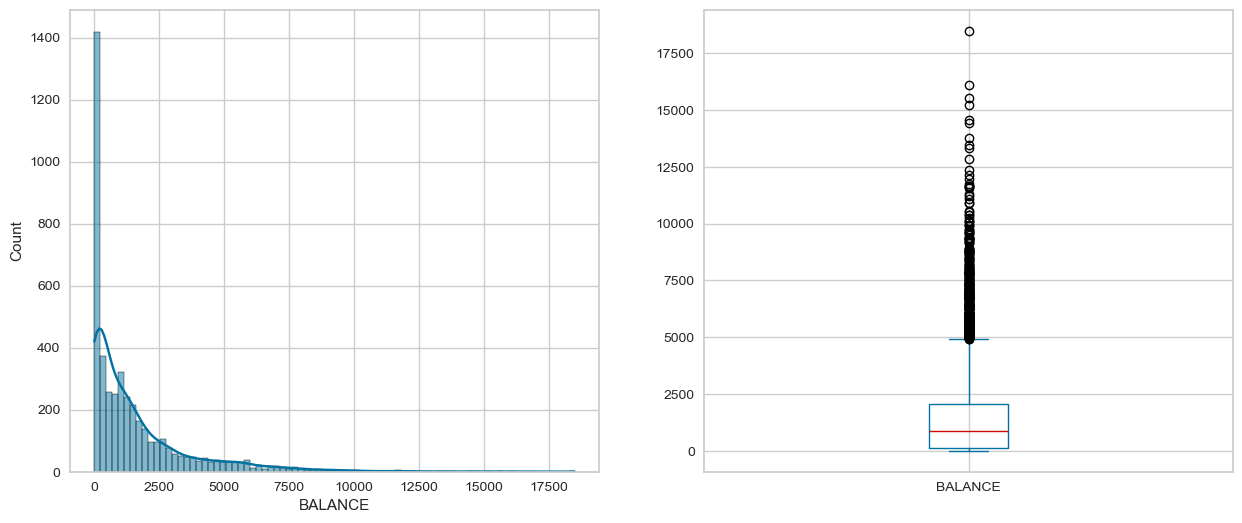

In [60]:
# Menampilkan distribusi nilai pada kolom BALANCE
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
sns.histplot(data=df, x="BALANCE", kde=True,ax=ax[0])
df['BALANCE'].plot(kind='box',ax=ax[1])

In [61]:
# Menampilkan variasi nilai balance
for i in [0,10,100,1000,2000, 3000, 4000, 5000] :
    if i > 0 :
        print(f'Presentase nilai balance kurang atau sama dengan {i} = {len(df.loc[df["BALANCE"] < i])*100/len(df.loc[df["BALANCE"] != 0])}')
    elif i == 0 :
        print(f'Presentase nilai balance kurang atau sama dengan {i} = {len(df.loc[df["BALANCE"] == i])*100/len(df.loc[df["BALANCE"] != 0])}')

Presentase nilai balance kurang atau sama dengan 0 = 0.970216606498195
Presentase nilai balance kurang atau sama dengan 10 = 5.595667870036101
Presentase nilai balance kurang atau sama dengan 100 = 23.307761732851986
Presentase nilai balance kurang atau sama dengan 1000 = 53.858303249097474
Presentase nilai balance kurang atau sama dengan 2000 = 75.20306859205776
Presentase nilai balance kurang atau sama dengan 3000 = 84.63447653429603
Presentase nilai balance kurang atau sama dengan 4000 = 89.53068592057761
Presentase nilai balance kurang atau sama dengan 5000 = 93.02797833935018


Dari data di atas dapat kita lihat jika mayoritas (93.02.2 %) nasabah memiliki balance kurang dari atau sama dengan 5000. Dari grafik histogram di atas dapat terlihat jika distribusi data bersifat positive skewed. Artinya terdapat sebagian nasabah yang memiliki nilai balance ekstrim positif dimana nilainya sangat jauh lebih besar dibandingkan nilai rata - rata balance populasi. Pada grafik boxplot di atas, kita dapat melihat titik - titik outlier yang merepresentasikan kelompok nasabah dengan nilai balance ekstrim positif dimana pada kelompok tersebut nilai balancenya memiliki rentang lebih dari 5000 hingga 18250. 

#### 5.2.2. Distribusi nilai pada kolom CREDIT_LIMIT

Presentase nilai kredit limit kurang atau sama dengan 8000 = 97.31843575418995


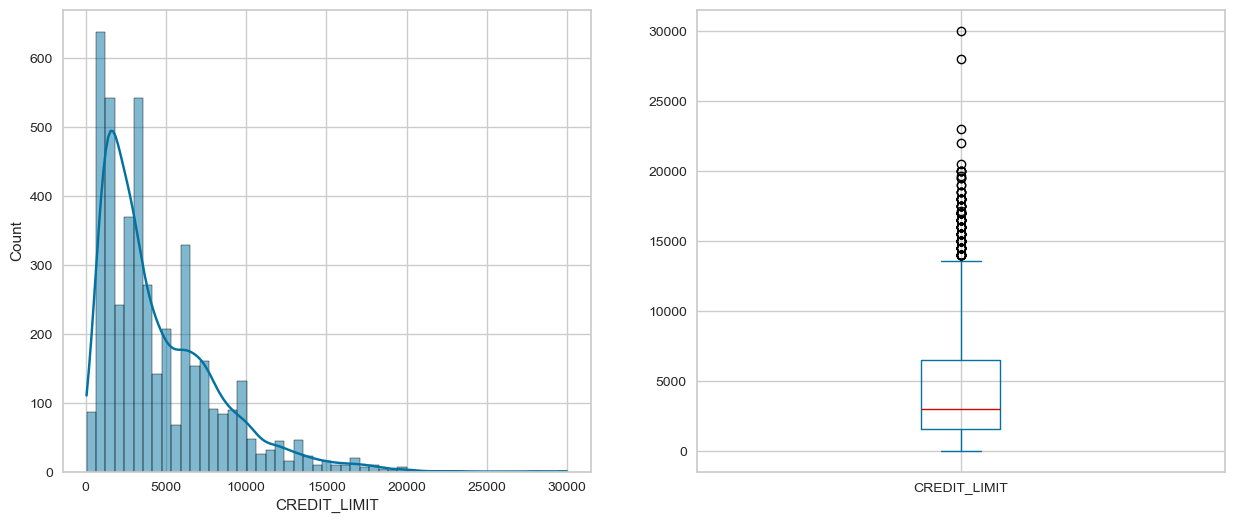

In [62]:
# Menampilkan distribusi nilai pada kolom CREDIT_LIMIT
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
sns.histplot(data=df, x="CREDIT_LIMIT", kde=True,ax=ax[0])
df['CREDIT_LIMIT'].plot(kind='box',ax=ax[1])

print(f'Presentase nilai kredit limit kurang atau sama dengan 8000 = {len(df.loc[df["CREDIT_LIMIT"] < 14000])*100/len(df)}')

Dari grafik di atas dapat terlihat jika sebagian besar data terdistribusi pada nilai credit limit sekitar 14000 dan sebagian kecilnya lebih terdistribusi pada nilai kredit limit di atas nilai tersebut (outlier).Distribusi datanya berjenis skewed positive, jika diinterpretasikan pada business domain hal ini memiliki arti bahwa sebagian kecil pemegang kartu kredit memiliki nilai credit limit jauh lebih besar dibandingkan nilai rata - rata credit limit. Dari grafik boxplot kita dapat melihat kelompok nasabah dengan nilai credit limit yang ekstrim positif (direpresentasikan dengan bundaran hitam). Kelompok nasabah ini memiliki rentang nilai kredit limit dari 14000 hingga 30000.

#### 5.2.3. Distribusi nilai pada kolom TENURE

<Axes: >

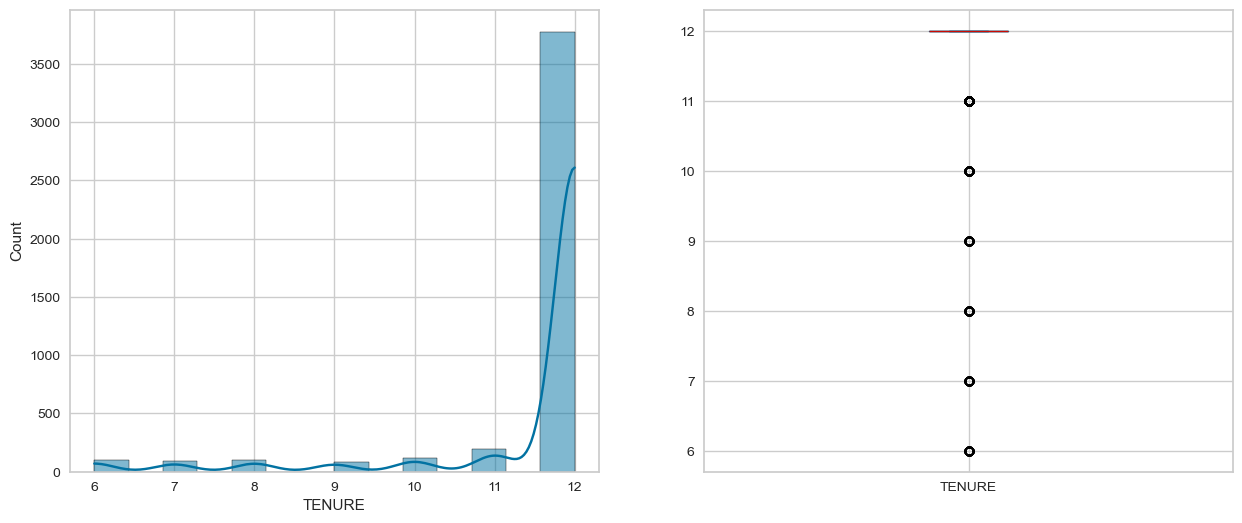

In [63]:
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
sns.histplot(data=df, x="TENURE", kde=True,ax=ax[0])
df['TENURE'].plot(kind='box',ax=ax[1])

In [64]:
pd.DataFrame(df.groupby('TENURE')['TENURE'].count())

TENURE
TENURE        
6          101
7           90
8           99
9           87
10         122
11         199
12        3777

In [65]:
print(f'Presentase nasabah dengan tenure 12 bulan = {len(df.loc[df["TENURE"] == 12])*100/len(df)}')

Presentase nasabah dengan tenure 12 bulan = 84.40223463687151


Dari grafik distribusi di atas kita dapat melihat jika distribusinya bersifat negative skewed, dimana sebagian besar pemegang kartu kredit memiliki tenure selama 12 bulan atau 1 tahun (3777 orang). Dari grafik dan table di atas dapat diketahui jika hanya sebagian kecil orang yang memiliki tenure dibawah 12 bulan. Dalam konteks bisnis, tenure adalah rentang waktu dimana kita harus membayar tagihan kredit secara berkala hingga batas waktu yang telah disepakati. Jika kita perluas maknanya dari sisi nasabah, tenure dapat memiliki arti keyakinan nasabah pada kemampuannya dalam membayar tagihan dalam rentang waktu tertentu.

#### 5.2.4. Distribusi nilai pada kolom PURCHASES_TRX

<Axes: >

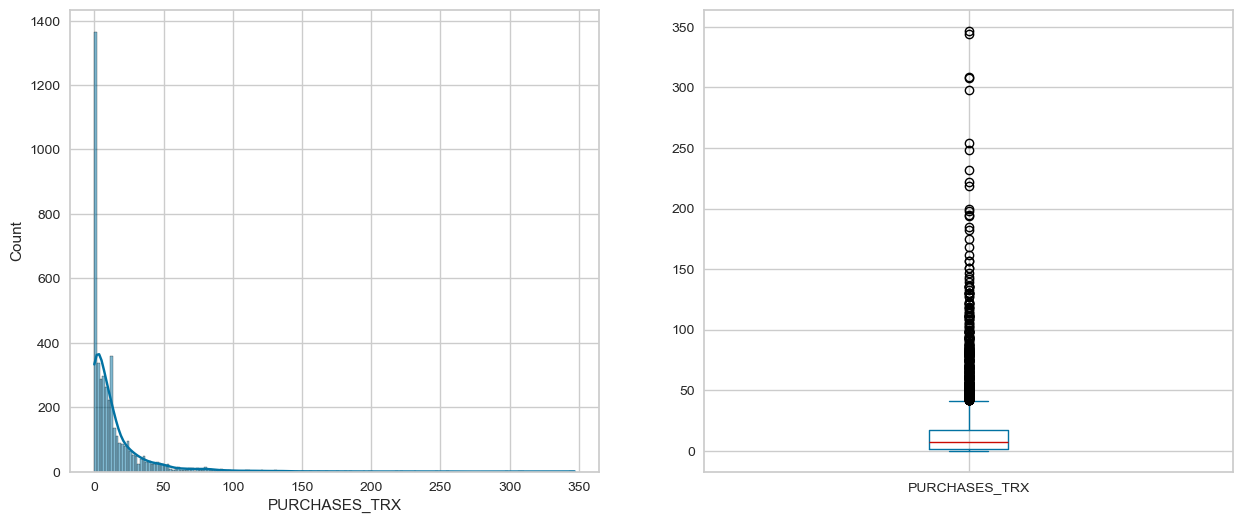

In [66]:
# Menampilkan distribusi nilai pada kolom PURCHASES_TRX
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
sns.histplot(data=df, x="PURCHASES_TRX", kde=True,ax=ax[0])
df['PURCHASES_TRX'].plot(kind='box',ax=ax[1])

PURCHASES_TRX adalah kolom yang menjelaskan seberapa banyak transaksi menggunakan kartu kredit dilakukan (kecuali cash advance). Dari data grafik di atas kita dapat mengambil kesimpulan bahwa dalam 6 bulan terakhir mayoritas nasabah melakukan transaksi pada rentang 0 sampai sekitar 45 kali. Selain itu, terdapat sebagian kecil nasabah yang melakukan transaksi kartu kredit lebih dari rentang tersebut bahkan hingga ada yang sampai 350 kali dalam 6 bulan terakhir (diwakili oleh simbol outliers pada boxplot)

### 5.2. Analisis bivariat

#### 5.2.1. Hubungan antara limit kartu kredit dengan masa tenure

Text(0, 0.5, 'Limit Kredit')

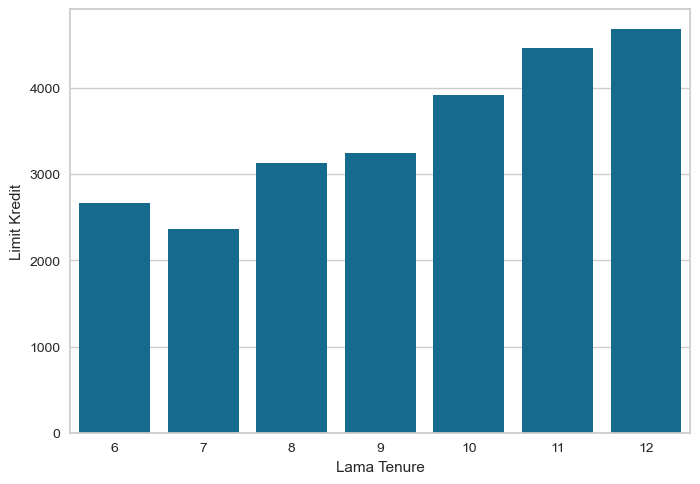

In [67]:
sns.barplot(data=df, x="TENURE", y="CREDIT_LIMIT",errorbar=None)
plt.xlabel('Lama Tenure')
plt.ylabel('Limit Kredit')

Dari grafik di atas dapat terlihat jika semakin lama masa tenure maka akan semakin besar credit limitnya. Hal ini mengindikasikan jika seseorang akan memilih masa tenure yang lebih panjang untuk credit limit yang besar.

#### 5.2.2. Hubungan antara limit kartu kredit dengan masa minimum payments

Text(0, 0.5, 'Minimum payment')

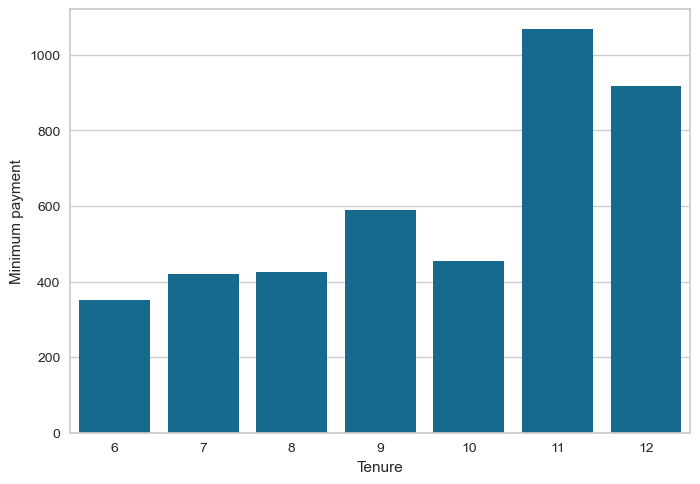

In [68]:
sns.barplot(data=df, x="TENURE", y="MINIMUM_PAYMENTS", errorbar=None)
plt.xlabel('Tenure')
plt.ylabel('Minimum payment')

Dari grafik di atas dapat dilihat jika minimum payment akan cenderung meningkat jika tenure nya semakin lama. Hal ini sedikit aneh karena seharusnya minimum payment akan semakin kecil jika tenure nya semakin lama. Hal ini disebabkan karena pembagi total tagihan (dalam hal ini jumlah bulan) akan semakin besar jika tenure nya semakin lama yang artinya minimum payment perbulannya akan semakin kecil. Kemungkinan hal ini terjadi karena ada faktor - faktor lain yang lebih besar dalam mempengaruhi nilai minimum payment

#### 5.2.3. Korelasi antar kolom 

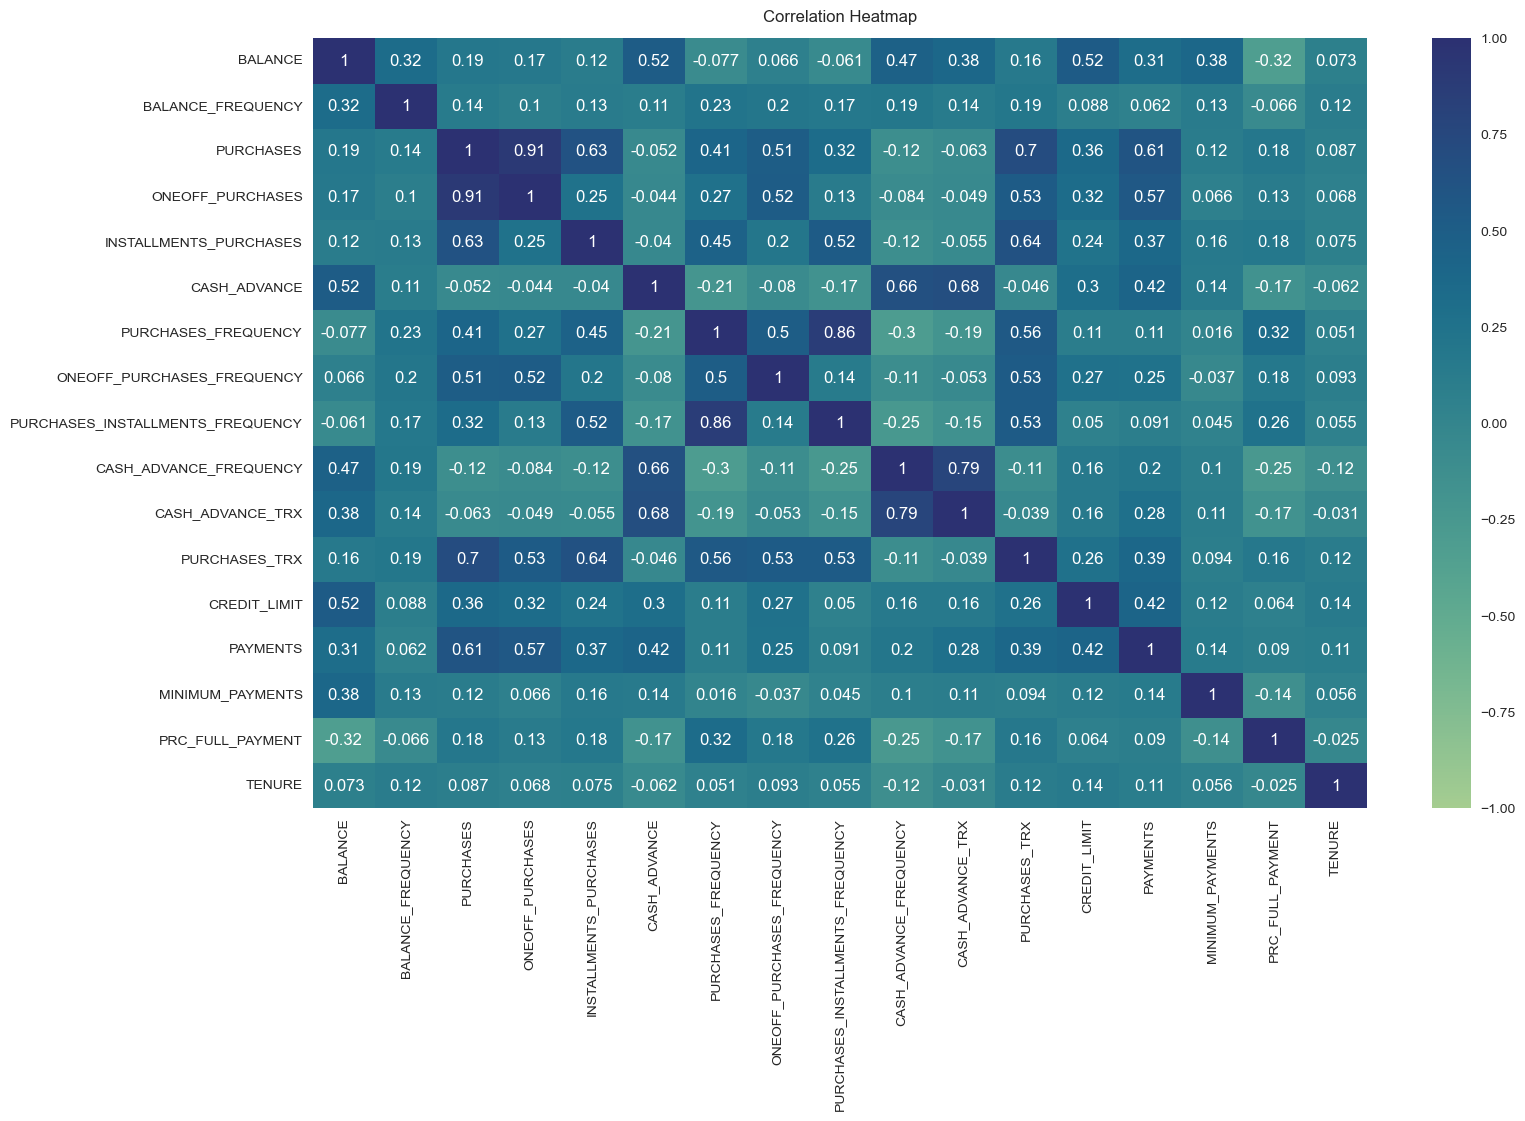

In [69]:
# Membuat heatmap korelasi
plt.figure(figsize=(17, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='crest')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# 6. Feature engineering

### 6.1. Handling missing values

Seperti yang sudah diketahui pada bab data loading, terdapat missing values pada kolom MINIMUM_PAYMENTS. Kita akan mengecek ulang missng values tersebut

In [70]:
# Cek jumlah missing values
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [71]:
# Cek dataframe dengan baris yang memiliki missing value
df.loc[df['MINIMUM_PAYMENTS'].isna()]

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1161    0.000000           0.000000      19.25              0.00   
2882   71.310815           0.090909       0.00              0.00   
351     0.000000           0.000000     140.04              0.00   
1163  269.816561           0.636364    1965.95           1965.95   
1164    0.859447           0.454545      23.00             23.00   
...          ...                ...        ...               ...   
6       0.228572           0.125000      60.00             60.00   
1344   53.697916           1.000000     114.49            114.49   
2301    0.000000           0.000000     609.21              0.00   
3121   39.642014           1.000000       0.00              0.00   
1130    0.000000           0.000000     102.72              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1161                   19.25      0.000000             0.083333   
2882                    0.00   1849.578078             0.000000   
351                   140.04      0.000000             1.000000   
1163                    0.00      0.000000             0.083333   
1164                    0.00      0.000000             0.083333   
...                      ...           ...                  ...   
6                       0.00      0.000000             0.125000   
1344                    0.00      0.000000             0.083333   
2301                  609.21      0.000000             0.900000   
3121                    0.00     45.175571             0.000000   
1130                  102.72      0.000000             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1161                    0.000000                          0.083333   
2882                    0.000000                          0.000000   
351                     0.000000                          1.000000   
1163                    0.083333                          0.000000   
1164                    0.083333                          0.000000   
...                          ...                               ...   
6                       0.125000                          0.000000   
1344                    0.083333                          0.000000   
2301                    0.000000                          0.800000   
3121                    0.000000                          0.000000   
1130                    0.000000                          1.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1161                0.000000                 0              1        4000.0   
2882                0.083333                 1              0        6000.0   
351                 0.000000                 0             12        1000.0   
1163                0.000000                 0              2        5500.0   
1164                0.000000                 0              1        3000.0   
...                      ...               ...            ...           ...   
6                   0.000000                 0              1        1500.0   
1344                0.000000                 0              1        7500.0   
2301                0.000000                 0              9        1000.0   
3121                0.083333                 1              0        5000.0   
1130                0.000000                 0             12        1500.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
1161    0.000000               NaN               0.0      12  
2882    0.000000               NaN               0.0      12  
351   129.905883               NaN               0.0      12  
1163    0.000000               NaN               0.0      12  
1164    0.000000               NaN               0.0      12  
...          ...               ...               ...     ...  
6     438.738982               NaN               0.0       8  
1344    0.000000               NaN               0.0      12  
2301  684.523752              

Minimum payment mendeskripsikan jumlah uang minimal yang harus dibayarkan agar pemegang kartu kredit tidak masuk dalam kategori gagal bayar yang akhirnya menyebabkan customer tidak dapat menggunakan layanan kartu kredit atau mendapatkan denda di pembayaran selanjutnya. Jumlah minimum payment seharusnya hampir berbeda - beda untuk tiap customer karena jumlah tersebut ditentukan oleh karakteristik dari tiap customer (history transaksi, credit limit, jumlah uang di bank, dll). Oleh karena itu, nilai minimum payment tidak boleh diimputasi karena dapat membuat hasil clustering menjadi bias. Untuk itu, kita akan melakukan penghapusan/drop baris yang memiliki nilai missing values pada kolom MINIMUM_PAYMENT

In [72]:
# Drop missing values
df.dropna(inplace=True)

In [73]:
# Cek hasil
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### 6.2. Handling outliers

Proses ini bertujuan untuk menangani outliers atau nilai ekstrim pada masing - masing kolom (kecuali target). Outliers sebenarnya dapat dibiarkan atau ditangani. Keputusan tersebut harus berdasarkan pertimbangan sebagai berikut : 

1. Jika model yang digunakan sensitif terhadap ouliers maka outliers harus ditangani (hapus atau capping)
2. Jika outliers disebabkan oleh suatu kesalahan tidak disengaja, technical error, atau error karena pengukuran maka outliers harus dihapus karena kemungkinan nilai outliers tidak akan didapatkan pada keadaan real
3. Jika model juga dibuat untuk menangani kasus - kasus ekstrim seperti penipuan atau kondisi yang tidak stabil maka outliers sebaiknya dibiarkan 
4. Konteks bisnis dan ilmiahnya. Jika nilai ekstrim tersebut di dunia nyata memang memiliki korelasi dengan target dan dianggap penting secara bisnis untuk memprediksi target, maka outliers dapat dibiarkan

Sebelum melakukan handling outliers, kita akan melihat dulu seberapa banyak outlier dari masing - masing kolom.

In [74]:
# Membuat dataframe copy
dfOut = df.copy(deep=True)

In [75]:
# Membuat variable list penampung nama kolom dan persen outliers
columns = []
percentOutliers = []

# Membuat fungsi untuk menghitung presentase outliers
def outlier(x, variable) :
    q1 = x[variable].quantile(0.25)
    q3 = x[variable].quantile(0.75)
    iqr = q3-q1

    up_bound = q3 + 1.5*iqr
    low_bound = q1 - 1.5*iqr

    outlier = x[variable][(x[variable]<low_bound) | (x[variable]>up_bound)]
    percent = len(outlier)*100/len(x[variable])
    percentOutliers.append(percent)
    columns.append(variable)

for col in dfOut :
    outlier(dfOut,col)

# Membuat dataframe outliers
outliersTable = pd.DataFrame([columns,percentOutliers]).T
outliersTable.rename(columns={0 : 'Columns', 1 : 'Percent Outliers'},inplace=True)

In [76]:
# Menampilkan dataframe persen outliers
outliersTable.sort_values(by='Percent Outliers')

Columns Percent Outliers
8   PURCHASES_INSTALLMENTS_FREQUENCY              0.0
6                PURCHASES_FREQUENCY              0.0
12                      CREDIT_LIMIT         2.731481
9             CASH_ADVANCE_FREQUENCY         3.981481
0                            BALANCE         8.032407
11                     PURCHASES_TRX         8.726852
7         ONEOFF_PURCHASES_FREQUENCY         8.842593
10                  CASH_ADVANCE_TRX         9.236111
2                          PURCHASES         9.259259
13                          PAYMENTS            9.375
4             INSTALLMENTS_PURCHASES         9.791667
14                  MINIMUM_PAYMENTS        10.208333
5                       CASH_ADVANCE        11.319444
3                   ONEOFF_PURCHASES         11.50463
15                  PRC_FULL_PAYMENT        15.231481
16                            TENURE        15.231481
1                  BALANCE_FREQUENCY        17.407407

Dari data table dan grafik boxplot di atas dapat terlihat jika sebagian besar kolom memiliki presentase outliers di atas 5 % dan hanya 4 kolom yang memiliki presentase outliers di bawah 5 %. Menurut saya, hampir seluruh kolom merupakan atribut/feature yang penting untuk melakukan clustering karena nilai - nilai pada feature tersebut dapat menentukan profil dan jumlah cluster. Jadi, handling outlier tidak akan dilakukan dengan cara menghapus melainkan dengan cara capping. Selain itu, kolom TENURE dan kolom - kolom yang menjelaskan mengenai frekuensi tidak akan saya capping dengan alasan sebagai berikut :

1. Kolom TENURE hanya memiliki sedikit variasi nilai (12 nilai yang mendeskripsikan bulan). Mengubah nilai ekstrimnya dapat memperkecil variasi nilai secara signifikan sehingga dapat berpengaruh besar terhadap hasil clustering

2. Kolom yang berkaitan dengan frekuensi hanya memiliki nilai dengan rentang 0 - 1 sehingga variasinya tidak terlalu banyak

In [77]:
# Membuat list penampung kolom
numcol = dfOut.drop(columns=['PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY', 'TENURE']).columns.tolist()

# Cek hasil
print(f'List of numeric columns : {numcol}')

List of numeric columns : ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']


In [78]:
# Membuat list penampung normal data dan normal columns
normalcol = []
normaldat = []

# Membuat list penampung skewed data dan skewed columns
skewmoderate = []
skewhigh = []
skewdat = []

# Looping untuk memfilter kolom dengan distribusi normal, moderate skewed, dan high skewed
for col in numcol :
    skewness = dfOut[col].skew()
    
    if (-0.5 <= skewness <= 0.5) :
        normalcol.append(col)
        normaldat.append([col,skewness])
    elif ((skewness >=-1) and (skewness <= -0.5)) or ((skewness <=1) and (skewness > 0.5)) :
        skewmoderate.append(col)
        skewdat.append([col,skewness,'Moderate'])
    elif (skewness < -1) or (skewness > 1) :
        skewhigh.append(col)
        skewdat.append([col,skewness,'High'])

In [79]:
# Cek hasil normal distribution
normaldat = pd.DataFrame(data=normaldat,columns=['Feature', 'Skewness'])
normaldat

Empty DataFrame
Columns: [Feature, Skewness]
Index: []

Dari hasil penilaian skewness terlihat jika tidak ada kolom yang memiliki distribusi normal.

In [80]:
# Cek hasil skewed distribution
skewdat = pd.DataFrame(data=skewdat,columns=['Feature', 'Skewness','Magnitude'])
skewdat

Feature   Skewness Magnitude
0                  BALANCE   2.306056      High
1                PURCHASES   6.982698      High
2         ONEOFF_PURCHASES   9.827307      High
3   INSTALLMENTS_PURCHASES   6.252820      High
4             CASH_ADVANCE   5.611537      High
5         CASH_ADVANCE_TRX   6.352409      High
6            PURCHASES_TRX   4.694067      High
7             CREDIT_LIMIT   1.487941      High
8                 PAYMENTS   5.720099      High
9         MINIMUM_PAYMENTS  14.669771      High
10        PRC_FULL_PAYMENT   1.918902      High

Karena semua kolom yang akan dicapping memiliki skewness dengan magnitude high, maka proses capping akan menggunakan metode IQR dengan fold 3

In [81]:
# Membuat object dan melakukan proses capping pada kolom berdistribusi high skewed yang berada di dalam xtrain-xtest 
wins_skew = Winsorizer(capping_method='iqr',
                       tail = 'both',
                       fold = 3,
                       variables = skewhigh,
                       missing_values = 'ignore')
dfCapped = wins_skew.fit_transform(dfOut)

In [82]:
# Membuat fungsi untuk menampilkan grafik
def outlierhandling(before, after, num):

    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))
    fig.suptitle(f'{num} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(before[num], bins=30, ax=axes[0, 0])
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=before[num], ax=axes[1, 0])
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(after[num], bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=after[num], ax=axes[1, 1])
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

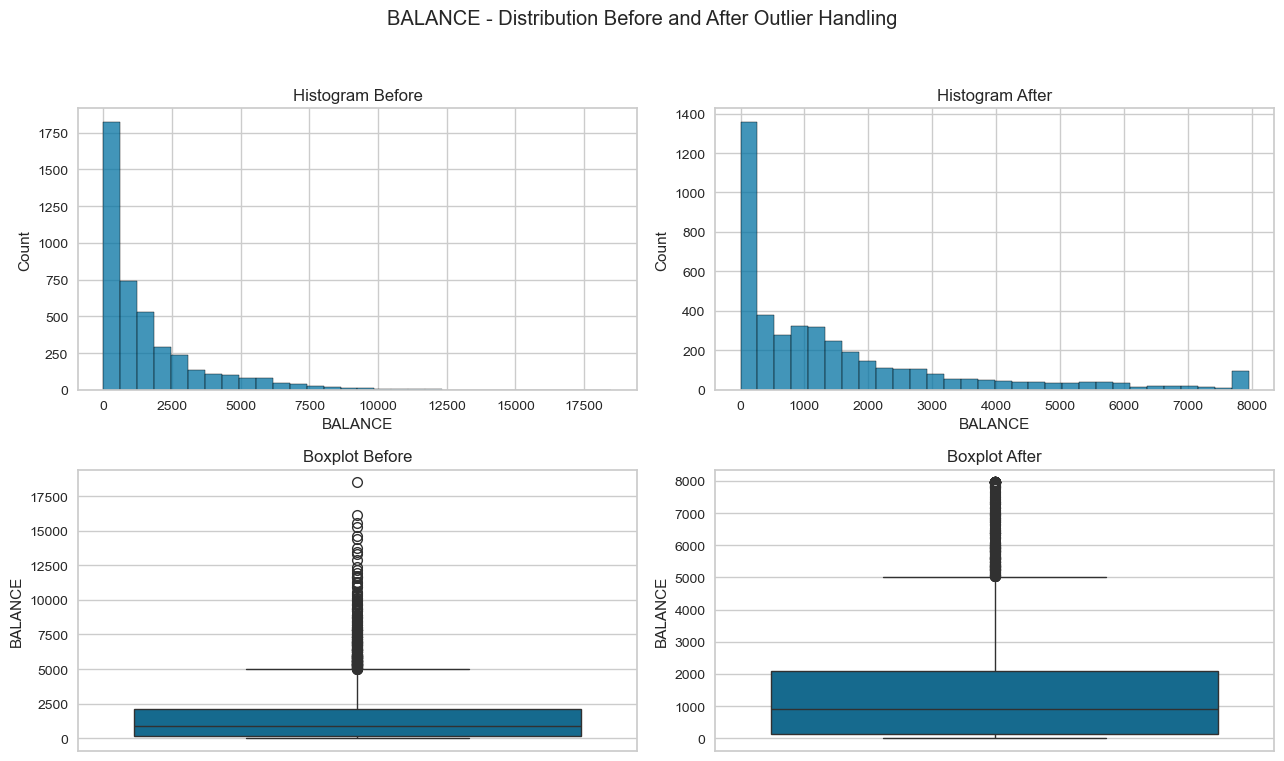

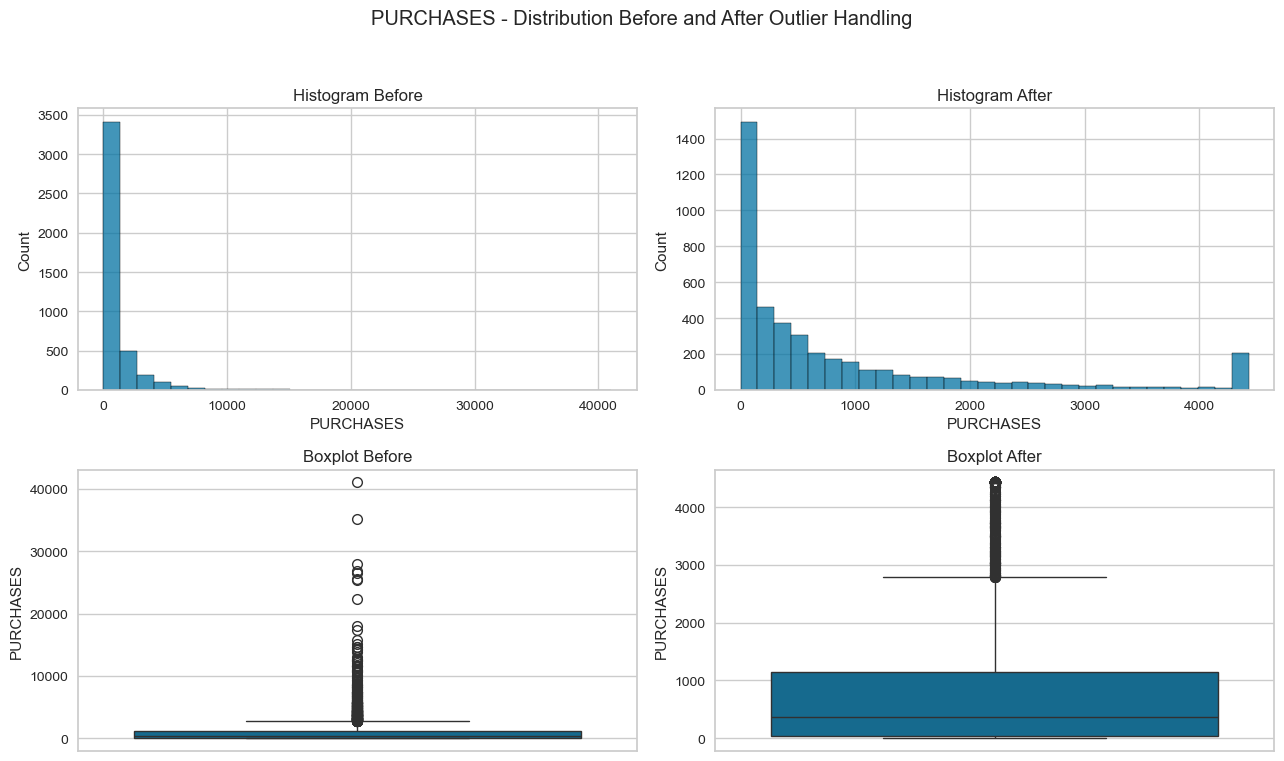

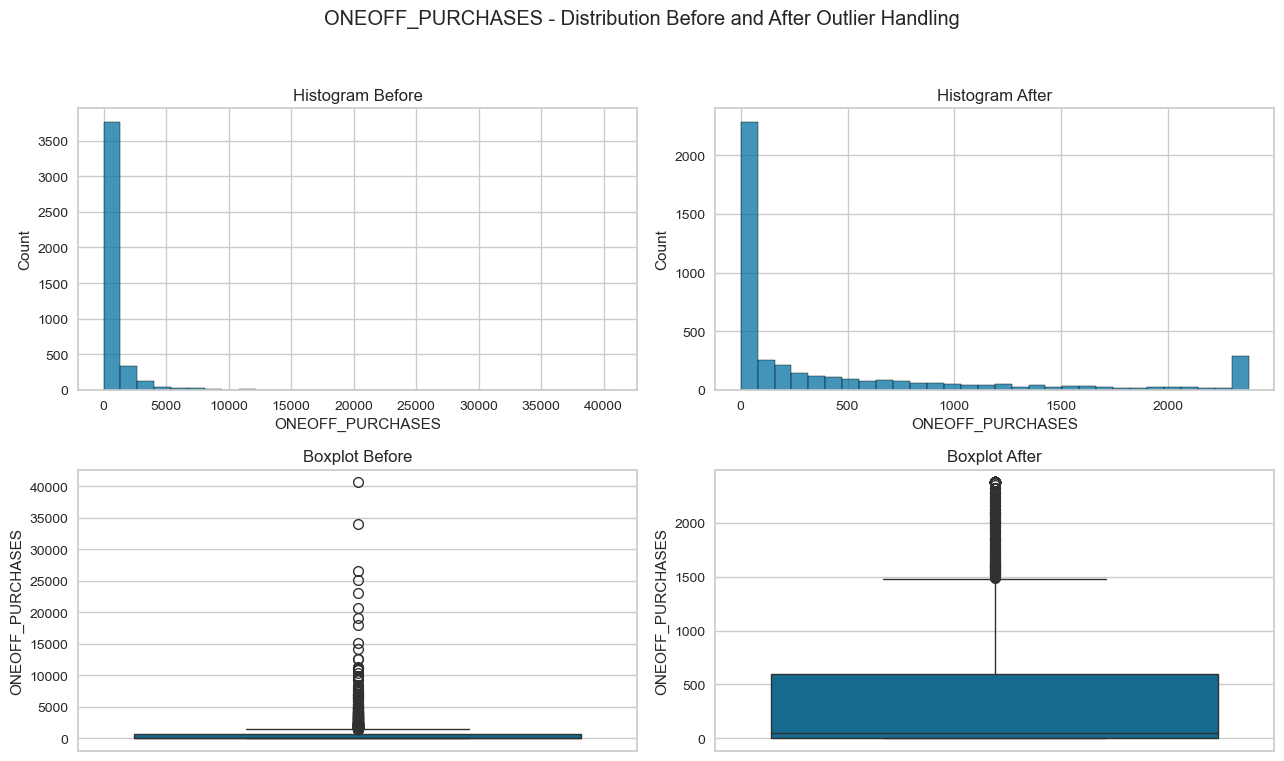

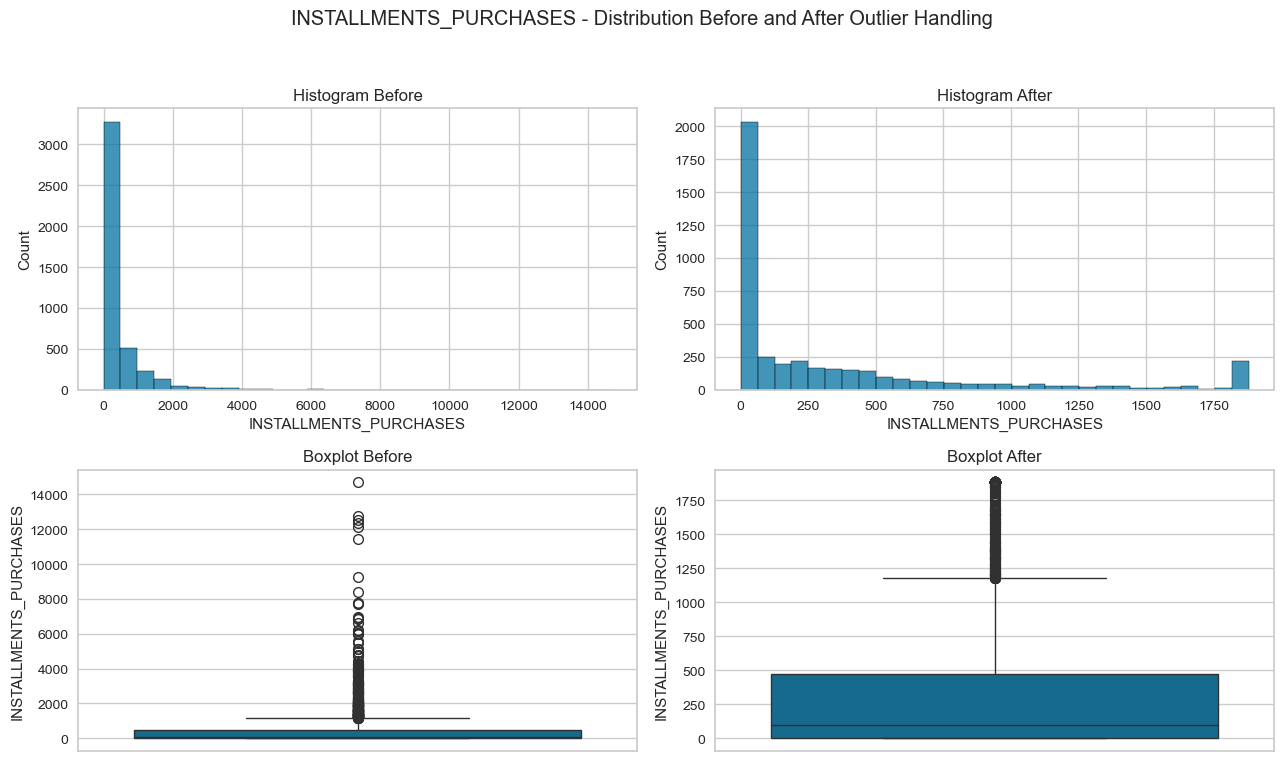

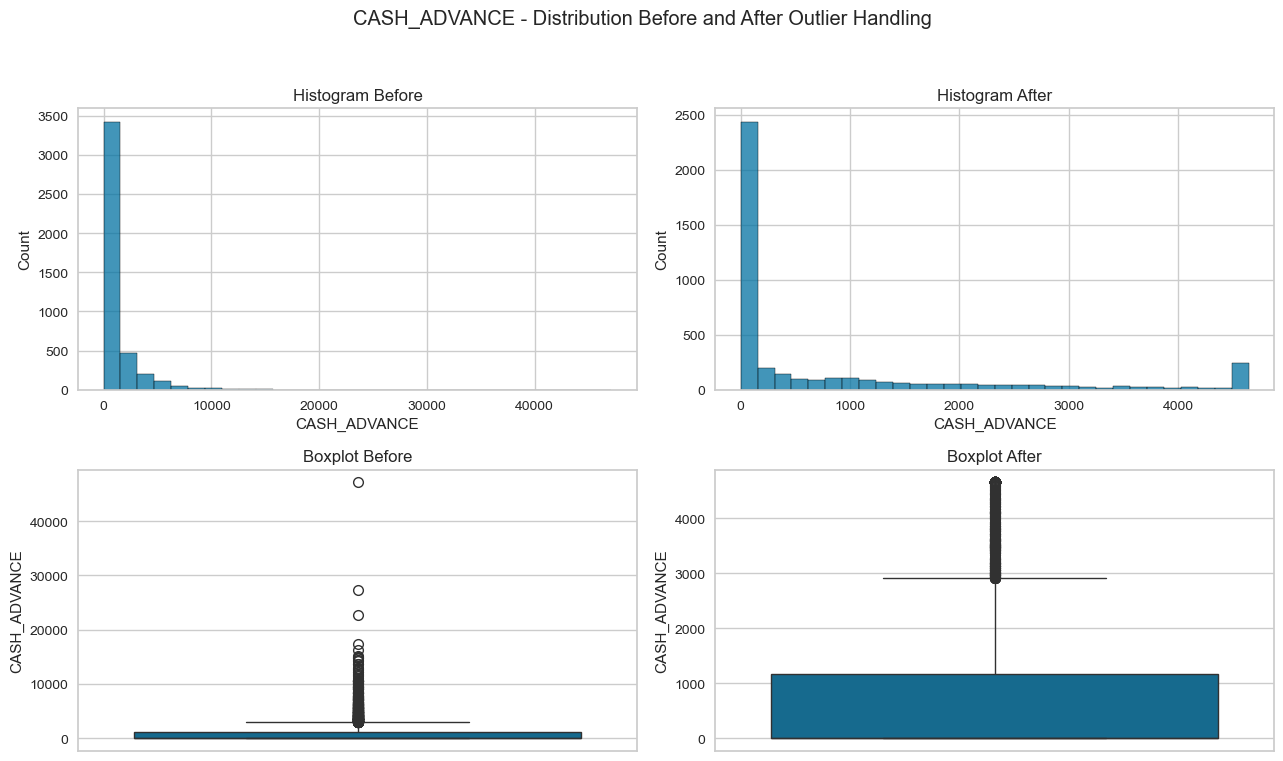

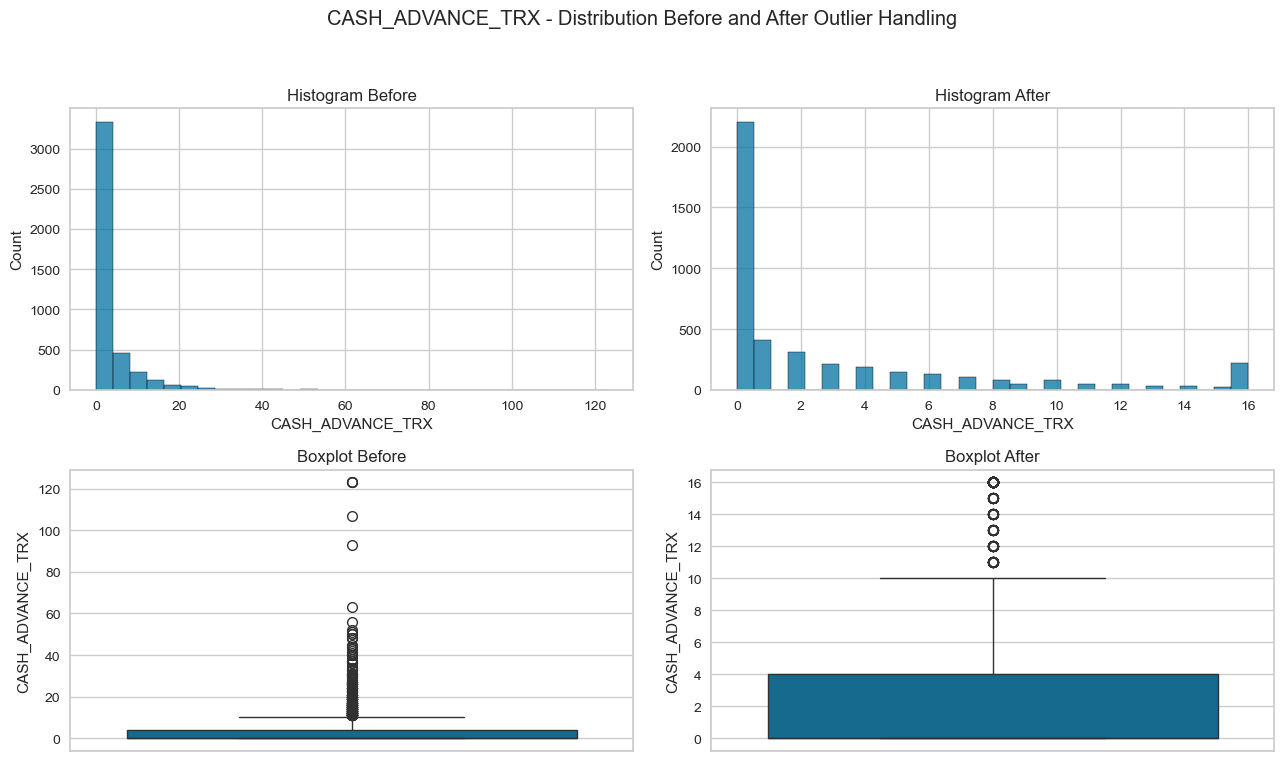

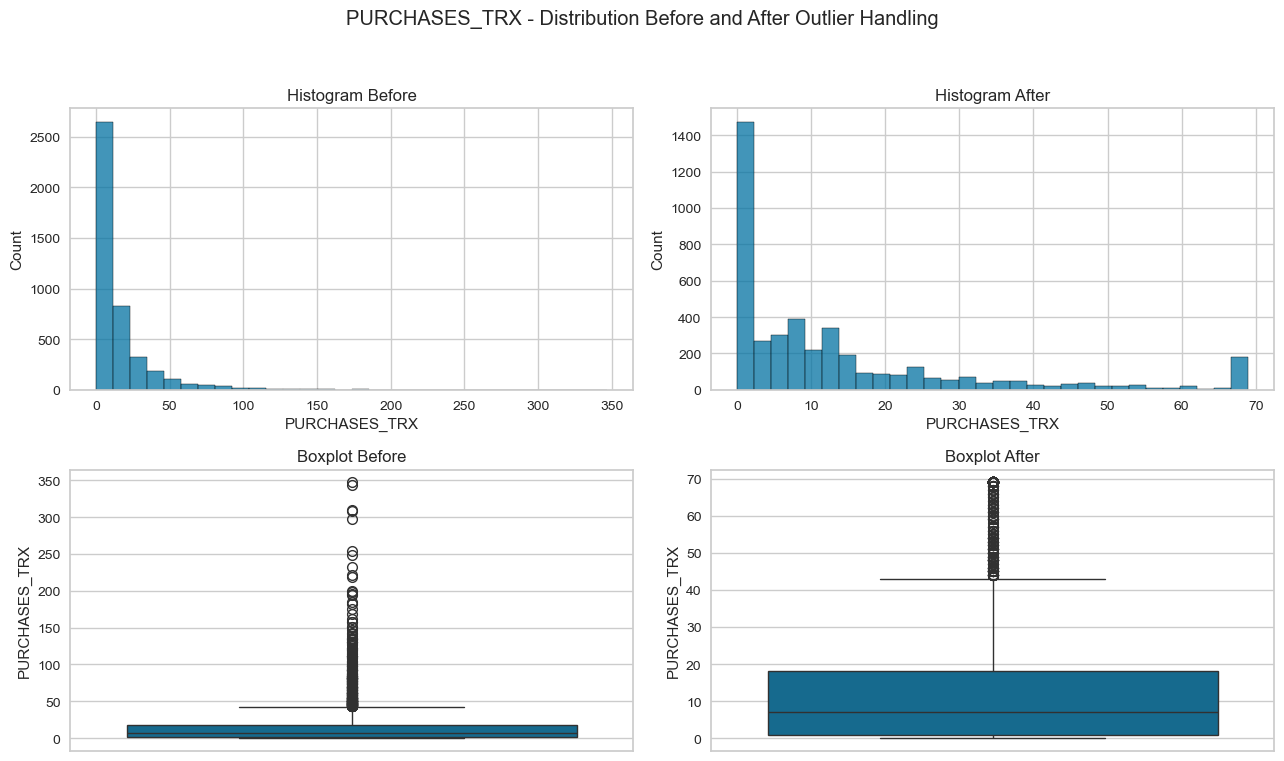

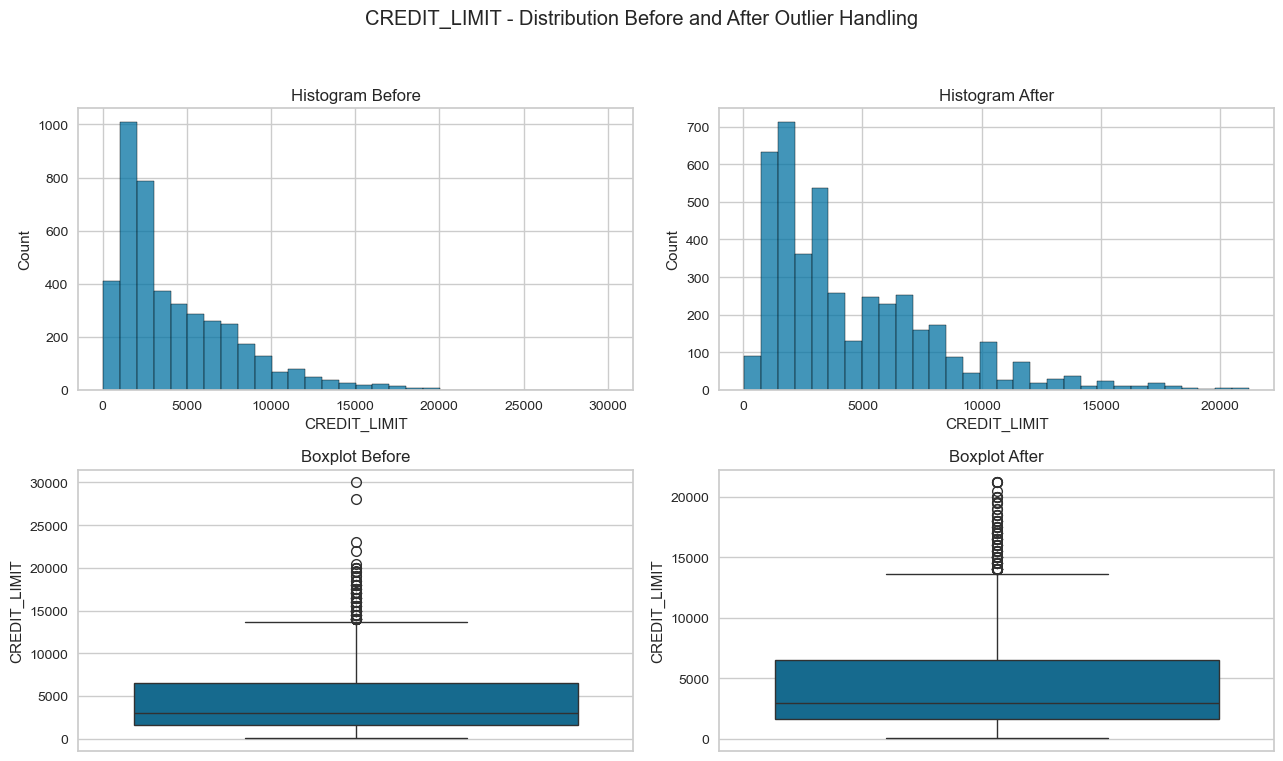

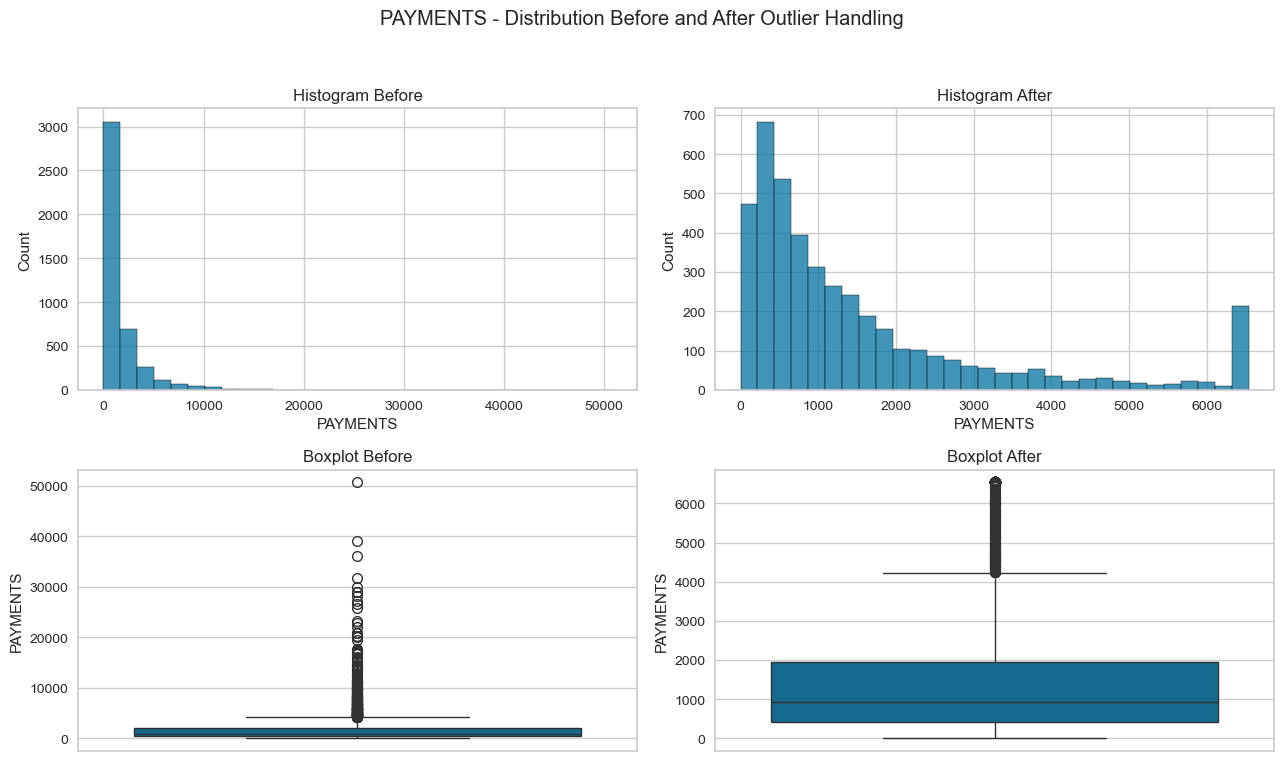

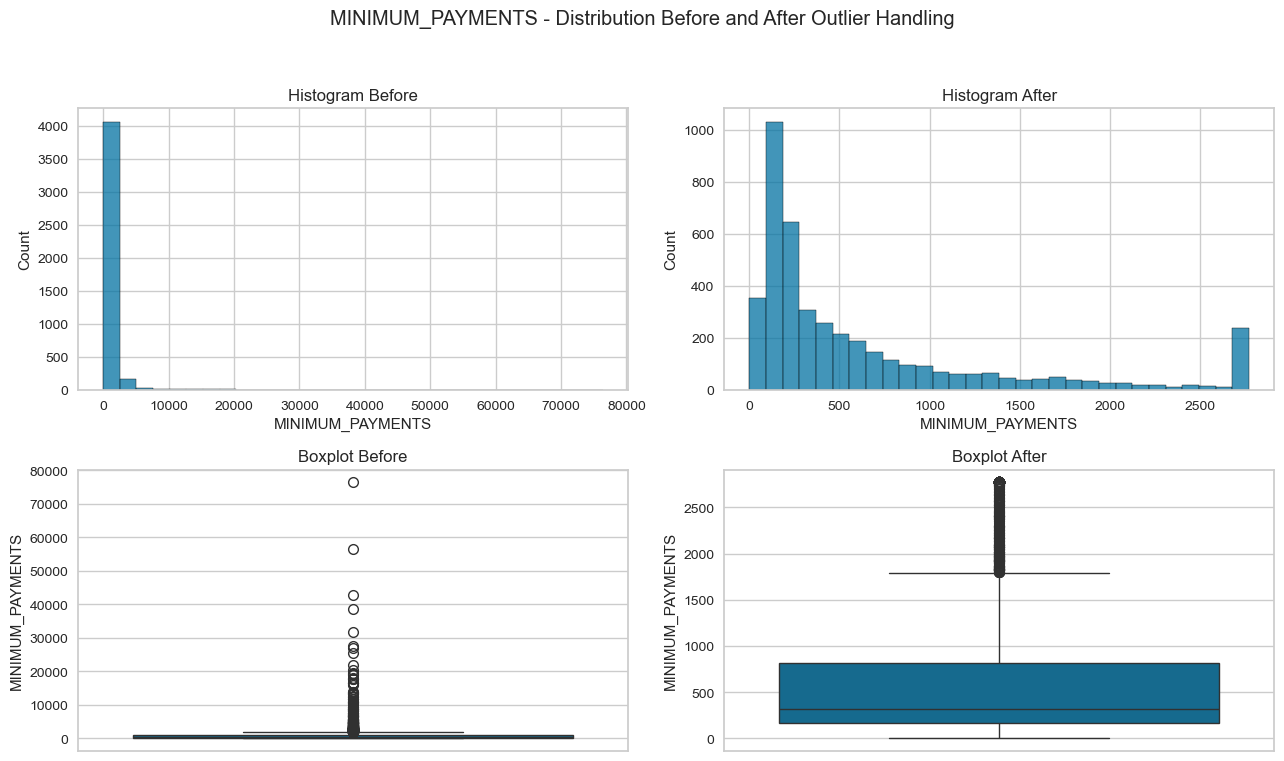

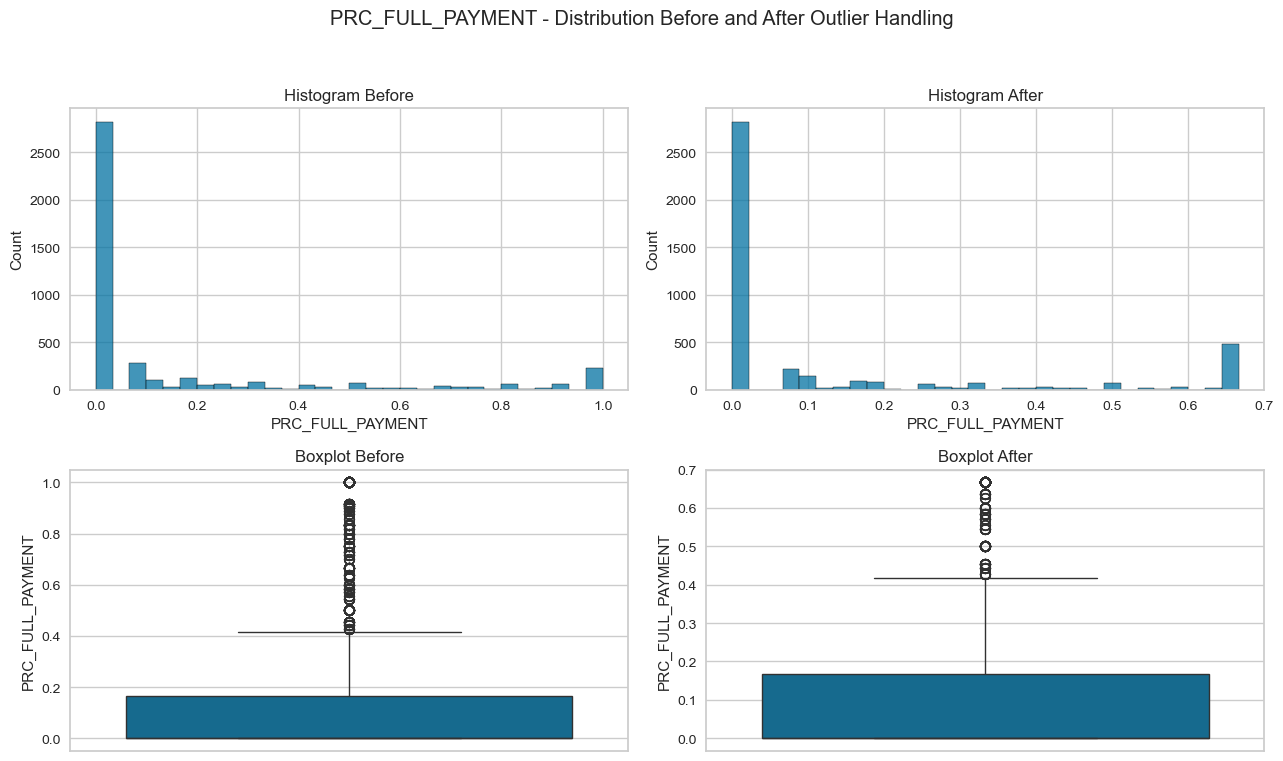

In [83]:
# Looping untuk menampilkan grafik histogram dan figure boxplot
for col in numcol :
    outlierhandling(dfOut, dfCapped, col)

Dapat kita lohat dari grafik - grafik di atas, sebagian besar outliers pada seluruh kolom yang dicapping berkurang nilainya hingga mendekati upper bound. Hal ini mengindikasikan jika capping sudah berhasil. Namun yang harus dicatat adalah, proses capping tidak merubah nilai outliers menjadi sama atau kurang dari upper/lower bound tetapi hanya mengurangi nilai outliers hingga mendekati masing - masing bound.

### 6.3. VIF selection

# Should i handle multicollinearity ?

Multicollinearity adalah masalah yang umumnya lebih penting dalam konteks regresi linear atau model apapun yang berbasis regresi dimana tujuan utamanya adalah untuk menilai pengaruh variabel independen terhadap variabel dependen. Dalam model clustering, tujuan utamanya adalah untuk mengelompokkan data berdasarkan kesamaan fitur atau karakteristik, bukan untuk memprediksi atau menjelaskan variabel dependen tertentu. Oleh karena itu, multicollinearity pada umunya tidak terlalu berpengaruh signifikan terhadapp hasil clustering. Selain itu, teknik reduksi dimensi seperti PCA (Principal Component Analysis) dapat digunakan untuk mengurangi efek multicollinearity dengan merangkum informasi yang ada dalam variabel berkorelasi tinggi menjadi beberapa principal components yang tidak berkorelasi.

Pada umumnya, dampak multicollinearity terhadap clustering adalah sebagai berikut :
1. Pengelompokan dapat didominasi oleh satu fitur tertentu sehingga bisa mengabaikan informasi penting dari fitur lainnya.
2. Fitur yang sangat berkorelasi membawa informasi yang redundant sehingga dapat ***menyebabkan beberapa variabel mempengaruhi hasil clustering lebih dari yang lain***

In [84]:
# Membuat fungsi untuk menghitung VIF
def calc_vif(x):
    global numcol
    vif = pd.DataFrame()
    vif["variables"] = x[numcol].columns
    vif["VIF"] = [variance_inflation_factor(x[numcol].values, i) for i in range(x[numcol].shape[1])]
    return(vif)

# Menghitung nilai VIF
vif = calc_vif(dfCapped)

# Cek hasil
vif

variables        VIF
0                  BALANCE   7.441890
1                PURCHASES  28.918612
2         ONEOFF_PURCHASES  14.468631
3   INSTALLMENTS_PURCHASES   8.637420
4             CASH_ADVANCE   4.702685
5         CASH_ADVANCE_TRX   3.513583
6            PURCHASES_TRX   5.390499
7             CREDIT_LIMIT   3.946345
8                 PAYMENTS   3.748701
9         MINIMUM_PAYMENTS   4.635281
10        PRC_FULL_PAYMENT   1.665170

Dari hasil di atas kita dapat melihat bahwa dari 11 kolom hanya 4 kolom yang memiliki nilai VIF sama atau kurang dari 4. Jika dianalisa secara definisi dan konteks bisnisnya, memang keseluruhan kolom yang dicari nilai VIF nya memiliki korelasi satu sama lain. Sebagai contoh, nilai pada kolom PURCHASE, ONEOFF_PURCHASE, dan INSTALLMENTS_PURCHASE menggambarkan nilai pembelian menggunakan kartu kredit pada mekanisme tertentu (angsuran atau membayar barang secara lunas), otomatis kolom - kolom tersebut akan mempengaruhi nilai dari BALANCE.

Walaupun banyak kolom memiliki nilai VIF lebih dari 4, namun dalam kasus ini saya memutuskan untuk tidak melakukan drop column pada kolom - kolom tersebut. Alasannya, disamping saya tidak memiliki business knowledge yang mendalam pada bidang ini, kolom - kolom tersebut jika dianalisa secara definisi dapat menjadi faktor yang signifikan dalam membentuk indentitas dari cluster pemgang kartu kredit sehingga penghapusan kolom - kolom tersebut dikhawatirkan dapat menghasilkan hasil yang kurang aktual.

### 6.4. Feature Scaling

Proses ini bertujuan untuk menyamakan skala nilai dari feature bertipe data numerik. Penyamaan skala diperlukan agar tidak ada feature yang mendominasi perhitungan model karena skala nilainya yang terlalu besar dibandingkan skala nilai feature numerik lain. Jika salah satu feature nilai - nilainya mendominasi perhitungan dibandingkan nilai - nilai feature lain, maka besar kemungkinan prediksi model akan menjadi bias karena prediksi model sebagian besar dipengaruhi oelh nilai - nilai yang jauh lebih besar dibandingkan nilai - nilai lainnya.

Terdapat 3 metode scaling, yaitu :

1. MinMax Scaler
   Digunakan untuk data yang tidak memiliki distribusi normal. Kekurangan dari metode ini adalah bahwa metode ini sensitif terhadap outliers

2. Standard Scaler
   Digunakan untuk data yang memiliki distribusi normal. Kekurangan dari metode ini adalah bahwa metode ini sensitif terhadap outliers dan tidak cocok terhadap data berdistribusi skewed

3. Robust Scaler
   Digunakan untuk data yang memiliki banyak outlier karena metode ini hanya menggunakan IQR dan median untuk melakukan scaling. Kekurangan dari metode ini adalah bahwa metode ini mengabaikan mean dalam perhitungannya (karena mean sensitif terhadap outliers)

Sebelum melakukan scaling, kita akan melakukan pengecekan terhadap outliers dan skewness dari masing - masing feature numerik. Walaupun sebelumnya kita telah melakukan proses capping outliers dan pengecekan skewness, namun kedua proses tersebut tidak merepresentasikan hasil setelah capping. Hal ini bertujuan agar kita tidak salah dalam memilih metode scaling dan agar dapat memilih metode yang sesuai dengan keadaan data feature.

In [85]:
# Membuat variable list penampung nama kolom dan persen outliers
columns = []
percentOutliers = []
skewness = []

# Membuat fungsi untuk menghitung presentase outliers
def outlier(x, variable) :
    q1 = x[variable].quantile(0.25)
    q3 = x[variable].quantile(0.75)
    iqr = q3-q1

    up_bound = q3 + 1.5*iqr
    low_bound = q1 - 1.5*iqr

    outlier = x[variable][(x[variable]<low_bound) | (x[variable]>up_bound)]
    percent = len(outlier)*100/len(x[variable])
    skewness.append(x[variable].skew())
    percentOutliers.append(percent)
    columns.append(variable)

for col in dfCapped :
    outlier(dfCapped,col)

# Membuat dataframe outliers
table = pd.DataFrame([columns,percentOutliers,skewness]).T
table.rename(columns={0 : 'Columns', 1 : 'Percent Outliers', 2: 'Skewness'},inplace=True)

In [86]:
# Cek hasil
table

Columns Percent Outliers  Skewness
0                            BALANCE         8.032407  1.706206
1                  BALANCE_FREQUENCY        17.407407 -2.085656
2                          PURCHASES         9.259259  1.795914
3                   ONEOFF_PURCHASES         11.50463  1.721561
4             INSTALLMENTS_PURCHASES         9.791667  1.756603
5                       CASH_ADVANCE        11.319444  1.673263
6                PURCHASES_FREQUENCY              0.0  0.030477
7         ONEOFF_PURCHASES_FREQUENCY         8.842593  1.514243
8   PURCHASES_INSTALLMENTS_FREQUENCY              0.0  0.489101
9             CASH_ADVANCE_FREQUENCY         3.981481  1.802858
10                  CASH_ADVANCE_TRX         9.236111  1.760131
11                     PURCHASES_TRX         8.726852  1.792168
12                      CREDIT_LIMIT         2.731481  1.409236
13                          PAYMENTS            9.375  1.713991
14                  MINIMUM_PAYMENTS        10.208333  1.706266
15                  PRC_FULL_PAYMENT        15.231481  1.586305
16                            TENURE        15.231481  -3.02604

Dari hasil di atas dapat disimpulkan bahwa 13 dari 17 feature memiliki presentase outliers lebih dari 5 % dan 15 dari 17 feature memiliki distribusi high skewed. Berdasarkan hasil tersebut, maka proses scaling akan menggunkana robust scaler.

In [87]:
# Membuat object scaler
scaler = RobustScaler()


# Fit transformation dan proses scaling
scaled = scaler.fit_transform(dfCapped)

# Mengambil nama kolom
scaledCol = scaler.get_feature_names_out(dfCapped.columns)

# Cek sebelum scaling
dfCapped.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
3137  1854.033230           1.000000    1013.50            576.00   
1751   129.836526           0.909091    1433.99            743.99   
1496    21.580264           0.909091     284.72              0.00   
8       16.379412           0.454545     178.15              0.00   
3164   686.657879           1.000000    2476.45           1624.50   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
3137                  437.50   1243.093189             0.500000   
1751                  690.00      0.000000             0.909091   
1496                  284.72      0.000000             0.666667   
8                     178.15      0.000000             0.250000   
3164                  851.95    253.273353             1.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
3137                    0.083333                          0.333333   
1751                    0.454545                          0.636364   
1496                    0.000000                          0.666667   
8                       0.000000                          0.250000   
3164                    0.750000                          1.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
3137                0.083333                 5             15        2000.0   
1751                0.000000                 0             19        4000.0   
1496                0.000000                 0             16        5000.0   
8                   0.000000                 0              3        5000.0   
3164                0.083333                 1             35        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
3137   654.473825       1524.375697          0.000000      12  
1751  1363.134203        141.648860          0.666668      11  
1496   344.161416        155.792859          0.666668      12  
8      229.376368         89.613822          0.181818      12  
3164  1600.734366        224.265608          0.083333      12

In [88]:
# Cek hasil
scaled = pd.DataFrame(scaled,columns=dfCapped.columns)
scaled.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  0.479570           0.000000   0.583665          0.887640   
1 -0.403696          -1.000000   0.967205          1.170322   
2 -0.459153          -1.000000  -0.081074         -0.081612   
3 -0.461818          -6.000011  -0.178280         -0.081612   
4 -0.118450           0.000000   1.918059          2.651982   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                0.731809      1.070070             0.000000   
1                1.269160      0.000000             0.490909   
2                0.406674      0.000000             0.200000   
3                0.179880      0.000000            -0.300000   
4                1.613809      0.218021             0.600000   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.222221   
1                    1.113637                          0.626263   
2                   -0.249999                          0.666667   
3                   -0.249999                          0.111111   
4                    2.000003                          1.111111   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.333332              1.25       0.470588     -0.204082   
1                0.000000              0.00       0.705882      0.204082   
2                0.000000              0.00       0.529412      0.408163   
3                0.000000              0.00      -0.235294      0.408163   
4                0.333332              0.25       1.647059      0.204082   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0 -0.175287          1.859912          0.000000     0.0  
1  0.287083         -0.264807          4.000000    -1.0  
2 -0.377752         -0.243073          4.000000     0.0  
3 -0.452644         -0.344765          1.090906     0.0  
4  0.442106         -0.137857          0.499997     0.0

### 6.5. Dimensionality reduction

Proses ini dilakukan untuk mengurangi dimensi dari dataset. Pengurangan dimensi diperlukan agar memaksimalkan kinerja model sekaligus mencegah munculnya redundansi pada informasi yang dihasilkan oleh suatu feature. Dalam proses ini, kita menggunakan metode PCA untuk mengurangi dimensi data.

In [89]:
# Proses train dengan mode PCA default
pca = PCA()
pca.fit(scaled)

PCA()

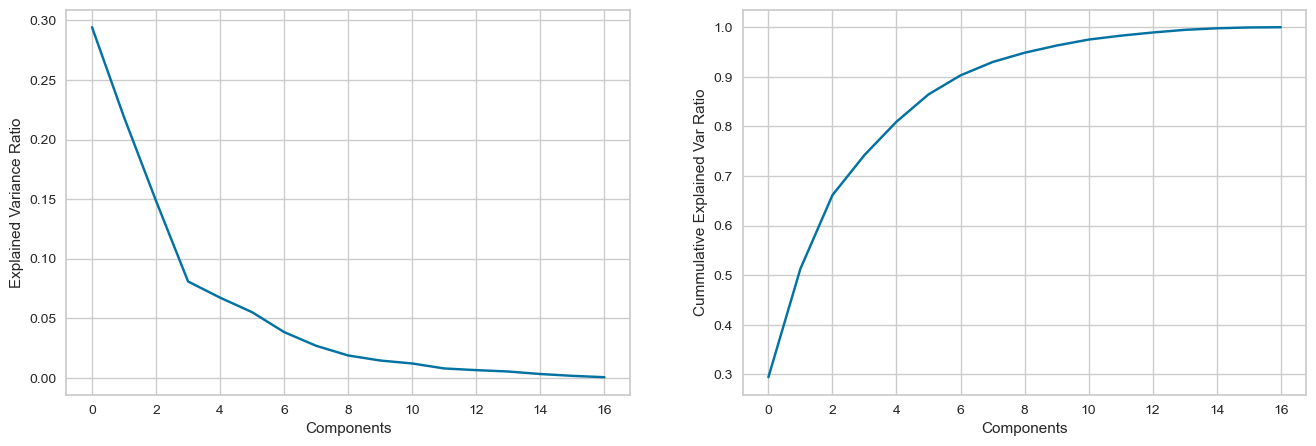

In [90]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5))

# Membuat grafik explained variance ratio
ax[0].plot(range(0,17),pca.explained_variance_ratio_)
ax[0].set_xlabel('Components')
ax[0].set_ylabel('Explained Variance Ratio')

# Membuat grafik cummulative explained variance ratio
ax[1].plot(range(0,17),np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Components')
ax[1].set_ylabel('Cummulative Explained Var Ratio')
plt.show()

Di sini saya memilih 95 % informasi data untuk dipertahankan. Alasannya, saya belum memiliki pengetahuan yang mendalam pada tipe bisnis ini (kartu kredit) dan saya ingin agar model juga dapat mengenali kasus - kasus ekstrim (informasi - informasi ekstrim yang terbentuk karena adanya outlier). Berdasarka nilai cummulative explained variances ratio, untuk mempertahankan 95 % informasi data maka kita membutuhkan 10 principal components.

In [91]:
# Mencari dimensi feature optimal agar 95% informasi dapat dipertahankan
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

10

In [92]:
# Proses train dengan 95% informasi dipertahankan
pca2 = PCA(n_components=0.95, random_state=100)
pca2.fit(scaled)

# Cek hasil
scaledPCA = pca2.transform(scaled)
# scaledPCA = pd.DataFrame(scaledPCA)
scaledPCA

array([[-1.35346997, -0.86709438, -0.25856602, ..., -0.61015602,
         0.73699924,  0.20217637],
       [ 0.22275781,  2.84256585, -0.92197151, ..., -0.4563297 ,
         0.10222045,  0.00901394],
       [ 1.11250881,  1.41325638, -1.85399838, ..., -0.58131745,
        -0.22296888,  0.02749382],
       ...,
       [ 0.15772654, -0.55856712, -2.22956347, ...,  0.18910086,
         0.05767331,  0.0423985 ],
       [-2.76852104, -3.31140824,  2.40470906, ..., -1.17431929,
        -0.37163836, -1.18919629],
       [ 2.10192974, -0.63761254, -1.09933731, ...,  0.68416934,
         0.04040237, -0.06131711]])

# 7. Model definition

Model yang akan digunakan untuk proses clustering kali ini adalah K-Mean. K-Mean merupakan model clustering yang cara kerjanya didasarkan atas perhitungan jarak data point ke centroid cluster terdekat. Semakin dekat jarak data point ke centroid cluster A dibandingkan jaraknya ke centroid dari cluster lain, maka semakin tinggi kemungkinan data point untuk dimasukan kedalam cluster A.

Alasan penggunaan K-Means dalam proses clustering ini dikarenakan beberapa hal berikut :
1. K-Means merupakan model yang memiliki kecepatan tinggi dalam melakukan clustering
2. Mudah untuk digunakan
3. Sangat mudah mencapai titik konvergen atau kestabilan posisi centroid dapat dicapai dengan iterasi yang sedikit

Hyperparameter yang digunakan adalah :
1. Nilai K
   Nilai ini mengatur berapa jumlah cluster yang ada. Nilai K optimal dipilih berdasarkan hasil iterasi dari metode tertentu seperti elbow method dan sillhouette score
2. max_iter
   Menentukan berapa banyak iterasi setiap nilai model dijalankan. Parameter ini digunakan untuk memastikan model dapat mencapai titik konvergensi
3. random_state
   Parameter ini digunakan untuk menghasilkan hasil clustering yang konsisten dengan dataset yang sama
4. init
   K-Means++ digunakan pada parameter ini. Intinya, parameter init digunakan untuk menentukan apakah centroid awal dipilih secara random atau berdasarkan algoritma tertentu. Di sini saya memilih metode kedua dimana centorid awal dipilih menggunakan algortima K-Meaans++

Saya menggunakan 2 metode untuk memilih nilai K optimal yaitu metode Elbow dan metode Sillhouette Scoring. Metode pertama lebih mudah digunakan dan mudah untuk diinterpretasikan namun penilaiannya cenderung subjektif. Metode kedua lebih kompleks untuk digunakan dan lebih sulit untuk diinterpretasikan namun penilaiannya dapat menjadi lebih objektif karena terdapat nilai matematis hasil perhitungan.


# 8. Model training

### 8.1. Mencari nilai K yang optimal

#### Elbow method manual

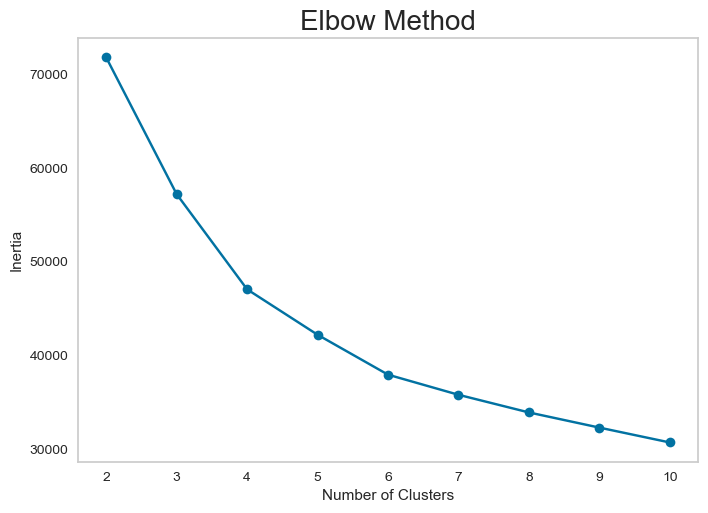

In [93]:
# Membuat list penampung nilai WCSS
inertia = []
random_state = 10
max_cluster = 10

# Train model untuk setiap i cluster
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(scaledPCA)
    inertia.append(km.inertia_)

# Menampilkan grafik elbow
plt.plot(range(2, max_cluster+1), inertia, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Dari grafik di atas dapat terlihat penurunan inertia tidak terlalu signifikan setelah cluster 6. Dari metode manual ini, cluster yang paling jumlah cluster yang paling optimal adalah 6. Yang perlu dijadikan catatan, metode elbow manual sangat subjektif sehingga perlu dilakukan tes dengan metode lain agar terdapat pembandingnya.

#### Elbow method menggunakan library yellowbrick

Elbow Method pada k = 10


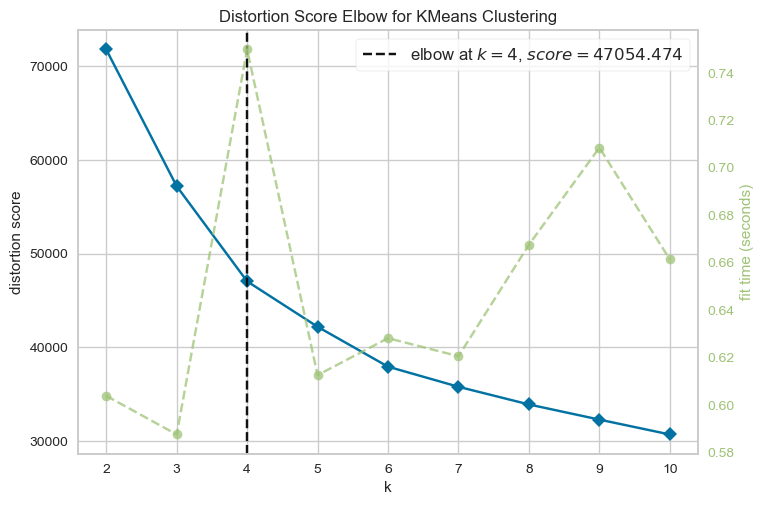

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
# Membuat model
km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

# Menampilkal grafik elbow
print('Elbow Method pada k = 10')
Elbow_M = KElbowVisualizer(km, k=10)
Elbow_M.fit(scaledPCA)
Elbow_M.show()

Dengan menggunakan library yellowbrick, jumlah cluster yang paling optimal adalah 4. Hasil ini lebih rendah 2 point jika dibandingkan dengan jumlah cluster optimal yang didapatkan dengan metode elbow manual. Menurut saya, ***berdasarkan metode elbow dengan library yellowbrick, nilai K optimalnya adalah 6 walaupun garis hitamnya menunjukan di angka 4***. ***Hal ini dikarenakan slope pada cluster 4 sampai 6 masih terlihat curam, sedangkan slope pada cluster 6 sampai 10 sudah lebih melandai***.

Kesimpulannya, dengan menggunakan metode elbow nilai K optimal yang didapatkan adalah sebesar 6.

#### Silhoutte score

Silhouette score adalah salah satu matriks evaluasi yang digunakan dalam analisis cluster untuk menentukan jumlah klaster optimal. Nilainya mengukur sejauh mana sebuah data point cocok dengan clusternya sendiri dibandingkan dengan cluster lain yang terdekat. Rentang nilai silhouette score berada di antara -1 hingga 1. Nilai positif menunjukkan data point tersebut sesuai dengan clusternya, nilai 0 menunjukan jika data point tersebut overlapping dengan cluster lain yang terdekat, sedangkan nilai negatif menunjukan bahwa data point lebih cocok di cluster lain yang terdekat atau dapat dianggap outlier.

In [95]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.31735145874494425
For n_clusters = 3 The average silhouette_score is : 0.30711607467430113
For n_clusters = 4 The average silhouette_score is : 0.28526641482515075
For n_clusters = 5 The average silhouette_score is : 0.2758116681439543
For n_clusters = 6 The average silhouette_score is : 0.2884235150526859
For n_clusters = 7 The average silhouette_score is : 0.2558869004390038
For n_clusters = 8 The average silhouette_score is : 0.2614623437709601
For n_clusters = 9 The average silhouette_score is : 0.24200959824877563


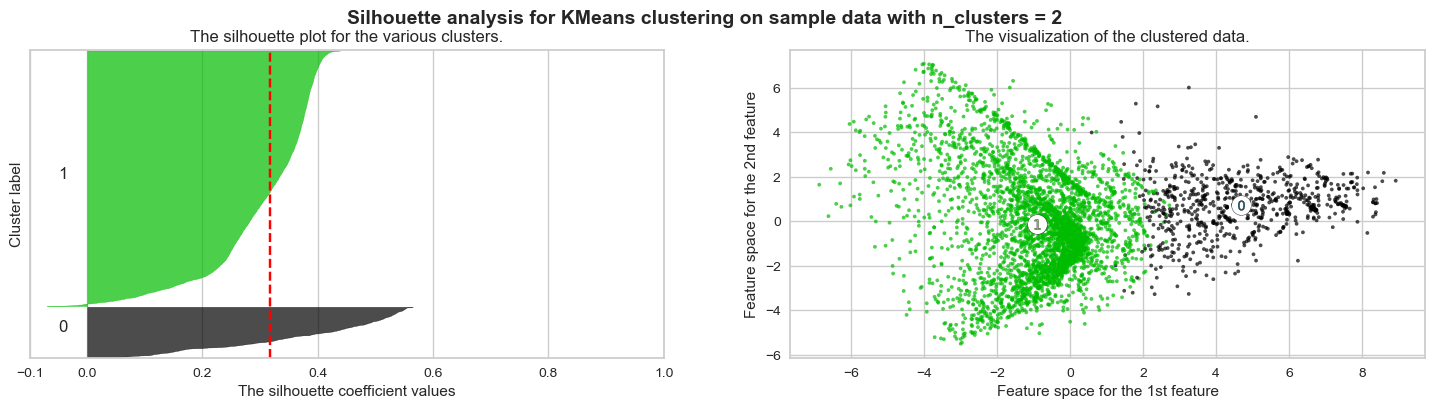

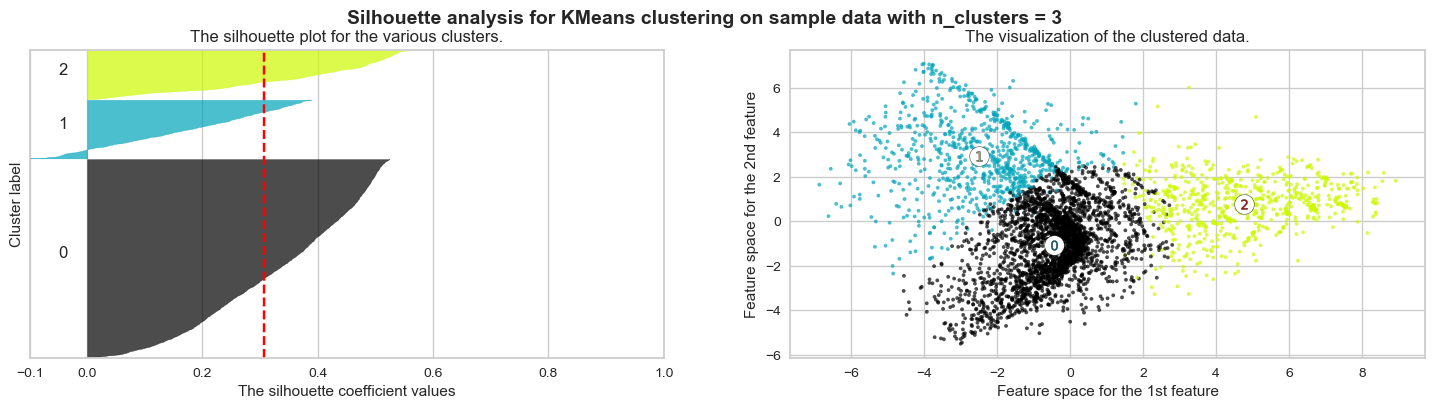

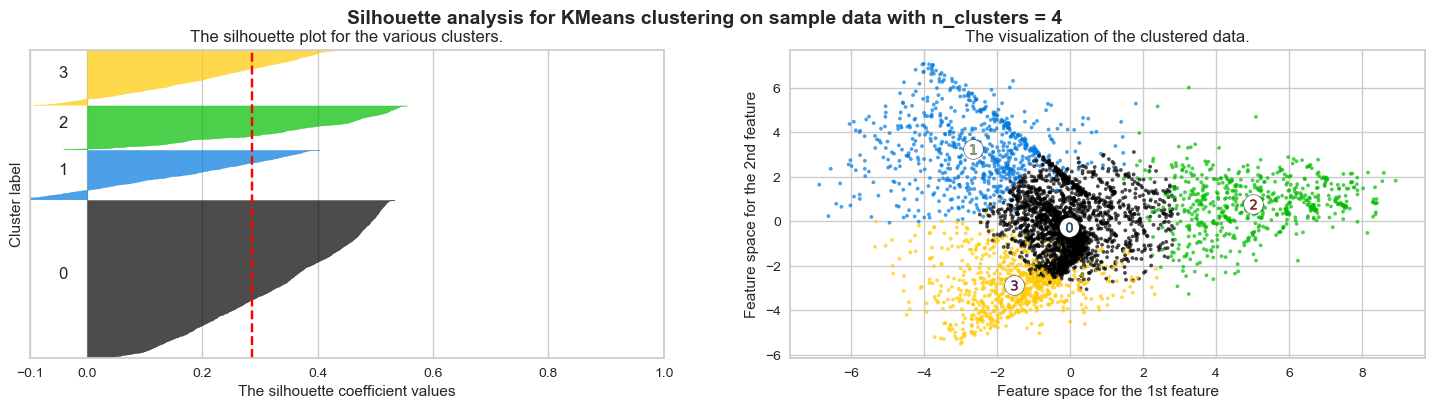

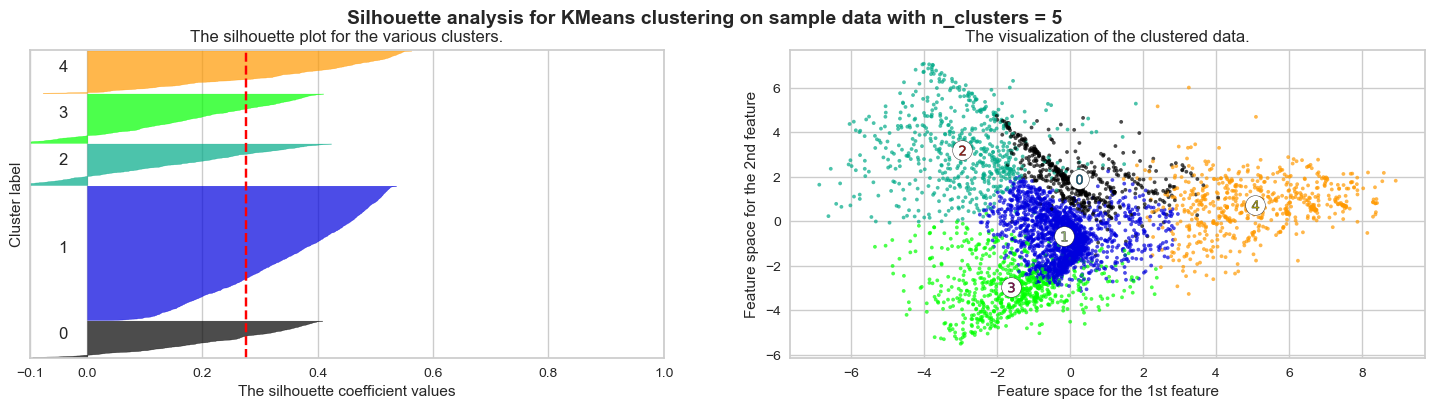

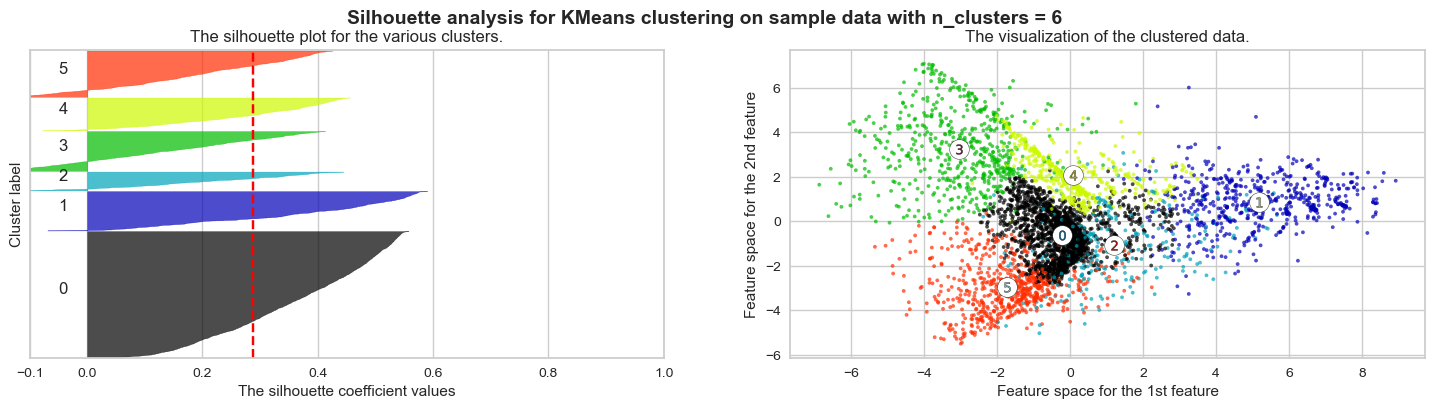

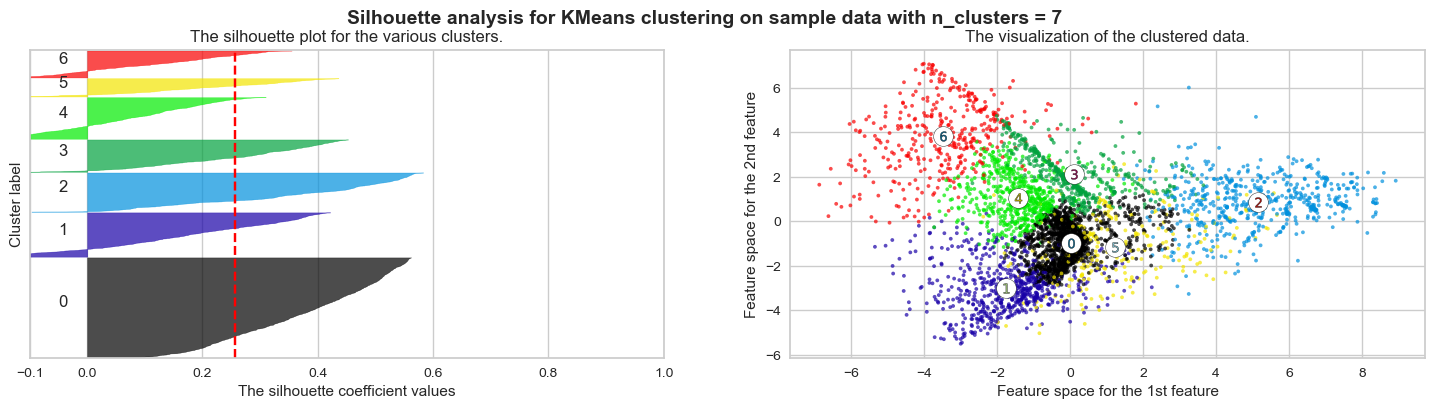

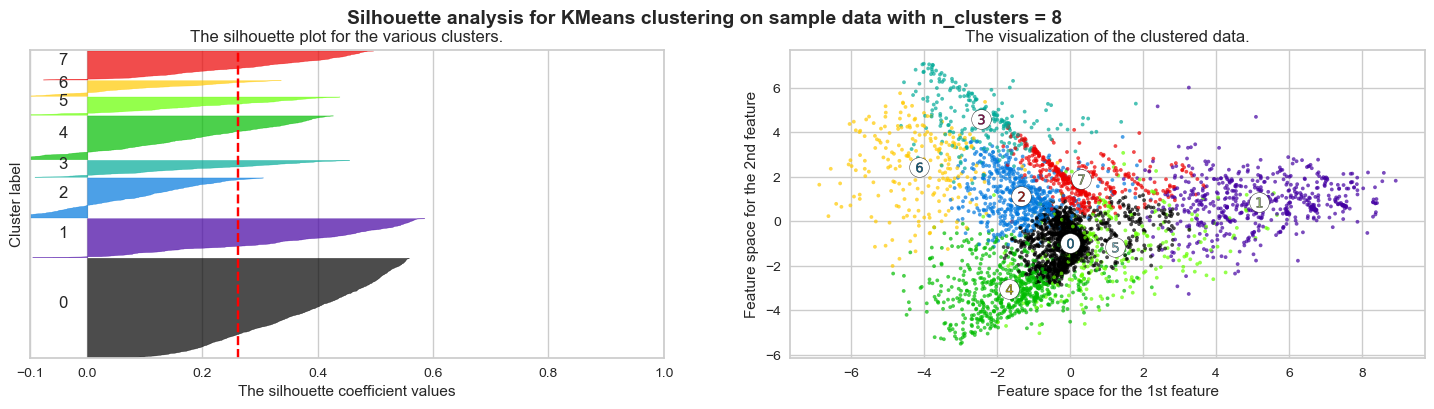

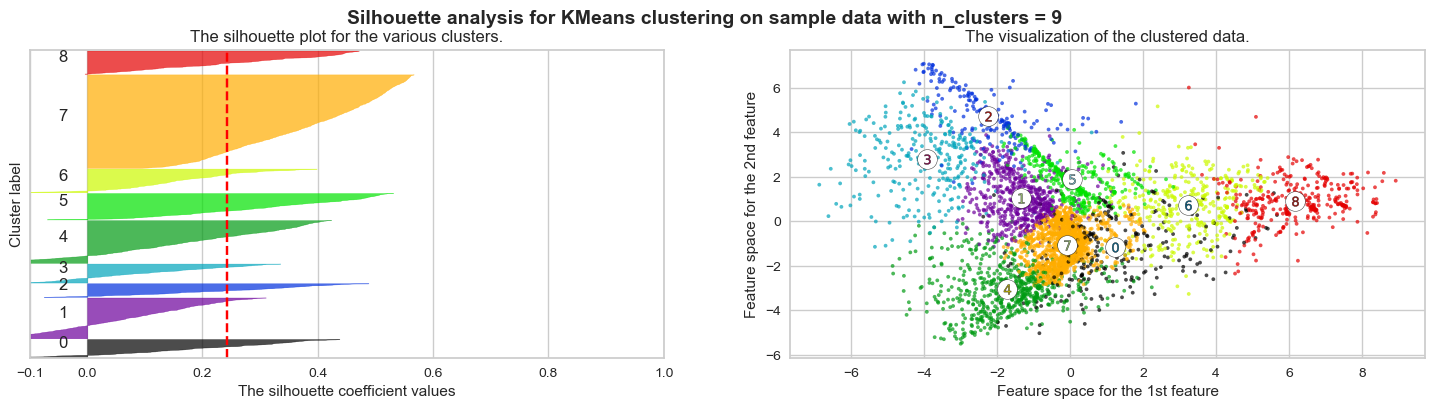

In [96]:
# Display the Silhouette Score and Plot Silhouette Plot
plot_silhouette(range(2, max_cluster), scaledPCA, random_state)

Berdasarkan grafik sillhouette di atas maka dapat disimpulkan :
1. Semua cluster pada tiap variasi k values memiliki sillhouette score di atas rata - rata 
2. 3 Nilai K dengan nilai sillhouette score rata - rata tertinggi adalah K = 2, K = 3, dan K = 6
3. Pada tiap variasi k values terdapat 1 cluster yang memiliki distribusi data point yang jauh lebih banyak dibandingkan cluster lainnya. Jika dilihat pada grafik plot 2 dimensi antara feature 1 (x) dan feature 2 (y), cluster dengan distribusi yang besar tersebut memiliki ciri khas distribusi data point yang terkonsentrasi pada x = 0 dan y = -1.5. Hal ini mengindikasikan tingkat kerapatan yang tinggi antar datapoint pada cluster tersebut, dengan kata lain cluster tersebut memiliki ciri khas tertentu (dari nilai feature) yang sulit disamakan dengan cluster lain.
4. Dari grafik di atas, menurut saya nilai k yang paling optimal adalah 6 dengan nilai sillhouette score rata - ratanya 0.288. Hal ini dikarenakan 5 dari 6 cluster memiliki distribusi yang hampir sama dan seluruh cluster memiliki sillhoutte score di atas sillhouette score rata - ratanya.
5. Pada nilai K = 6, terdapat beberapa cluster yang sebagian kecilnya memiliki sillhouette score dibawah 0 atau minus. Hal ini menunjukan jika ada beberapa data point yang jaraknya sangat jauh dari centroid/pusat cluster. Data point ini dapat dianggap sebagai outlier

***Dari hasil metode elbow dan sillhouette score, maka dipilih nilai K optimal sebesar 6***

### 8.2. Model training


In [97]:
# Membuat objek model dengan K optimal
kmFinal = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

# Model training dengan K optimal
kmFinal.fit(scaledPCA)

KMeans(n_clusters=6, n_init=10, random_state=10)

In [98]:
pred = kmFinal.fit_predict(scaledPCA)
# Cek hasil
pred

array([0, 4, 4, ..., 0, 5, 2])

In [99]:
# Membuat kolom Cluster pada dataframe utama
dfCl = df.copy(deep=True)

# Cek hasil
dfCl['Cluster'] = pred

In [100]:
# Mengganti nilai pada kolom Cluster
dfCl['Cluster'] = dfCl['Cluster'].replace(0,10)
dfCl['Cluster'] = dfCl['Cluster'].replace(1,11)
dfCl['Cluster'] = dfCl['Cluster'].replace(2,12)
dfCl['Cluster'] = dfCl['Cluster'].replace(3,13)
dfCl['Cluster'] = dfCl['Cluster'].replace(4,14)
dfCl['Cluster'] = dfCl['Cluster'].replace(5,15)

# Mengganti nilai pada kolom Cluster
dfCl['Cluster'] = dfCl['Cluster'].replace(10,1)
dfCl['Cluster'] = dfCl['Cluster'].replace(11,2)
dfCl['Cluster'] = dfCl['Cluster'].replace(12,3)
dfCl['Cluster'] = dfCl['Cluster'].replace(13,4)
dfCl['Cluster'] = dfCl['Cluster'].replace(14,5)
dfCl['Cluster'] = dfCl['Cluster'].replace(15,6)

# 9. Model evaluation dan profiling

Pada model evaluation atau profiling cluster, tidak semua feature akan digunakan sebagai unsur dari culster profile, hanya beberapa feature yang dianggap penting saja berdasarkan sisi bisnis nya. Berikut daftar feature - featurenya :

1. Purchase

   Total uang yang dibelanjakan atau dipinjam dari bank. Nilai purchase merupakan hasil penjumlahan antara One off purchase dan Purchase installements


2. Purchase trancactions

   Jumlah transaksi pembelian dengan kartu kredit


3. One off purchase

   Total uang yang dipinjam dari bank dan di bayar penuh pada tagihan berikutnya


4. Purchase Installments

   Total uang yang dipinjam dari bank menggunakan kartu kredit dan dibayar secara periodik (cicilan)


5. Cash advance

   Total uang tunai yang dipinjam dari bank menggunakan kartu kredit 


6. Cash advance transactions

   Jumlah transaksi cash advance


7. Credit limit

   Total uang yang dapat digunakan dengan kartu kredit


8. Tenure

   Jangka untuk melunasi cicilan kartu kredit (transaksi purchase installements)


9. Percent of full payment

   Rasio uang yang sudah dibayarkan dengan total uang yang dipinjam dari bank menggunakan kartu kredit


Sumber :
- https://www.ocbc.id/id/article/2023/04/26/pembayaran-minimum-kartu-kredit
- https://uk.virginmoney.com/virgin/service/credit-card/messages/information-about-credit-balances.jsp
- https://www.consumerfinance.gov/ask-cfpb/what-is-a-credit-balance-on-my-credit-card-bill-en-42/#:~:text=If%20the%20total%20of%20your,credit%20card%20company%20owes%20you.
- https://www.bankrate.com/credit-cards/advice/credit-card-information-the-basics-to-know/#account

### 9.1. Distribusi pemilik kartu kredit pada tiap cluster

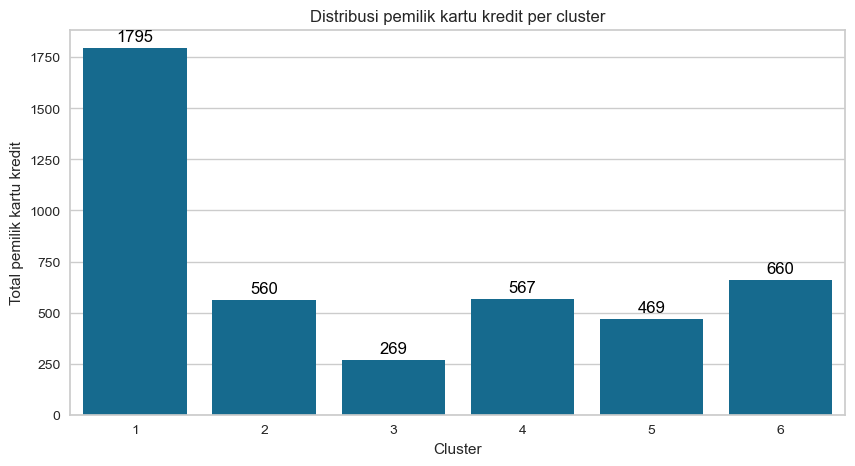

In [101]:
# Grafik jumlah pemegang kartu kredit berdasarkan pendidikan terakhir
plt.figure(figsize = (10,5))
ax = sns.countplot(dfCl, x="Cluster")

# Looping untuk menampilkan jumlah pemiliki kartu
for p in ax.patches:
    count = p.get_height()
    ax.annotate(f'{count:.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.title('Distribusi pemilik kartu kredit per cluster')
plt.xlabel('Cluster')
plt.ylabel('Total pemilik kartu kredit')

plt.show()

Text(0.5, 1.0, 'Presentase nasabah dari cluster')

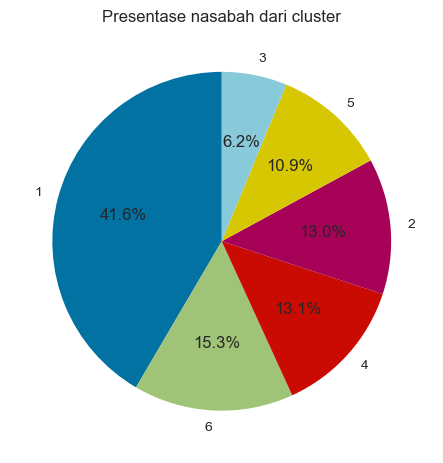

In [102]:
# Membuat pie chart presentase nasabah dari cluster
cluster_counts = dfCl['Cluster'].value_counts(normalize=True) * 100
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Presentase nasabah dari cluster')

<Axes: >

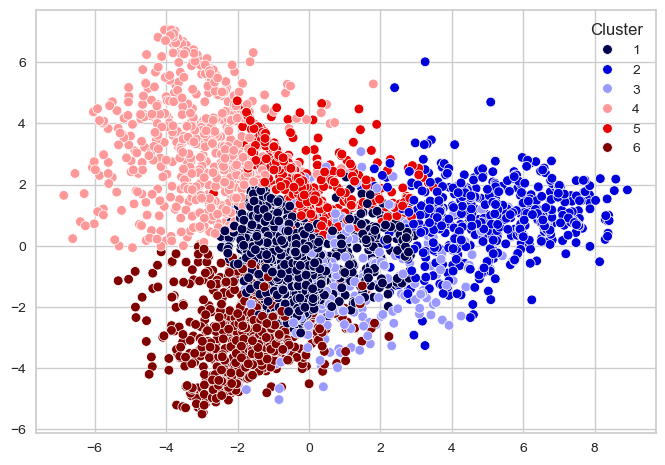

In [103]:
# Persebaran data point tiap cluster
sns.scatterplot(x=scaledPCA[:,0], y=scaledPCA[:,1], hue=dfCl['Cluster'], palette='seismic')

Dari grafik di atas dapat diambil kesimpulan sebagai berikut :

1. Cluster 1 memiliki distribusi pemakai kartu kredit terbesar (1795 orang). Cluster 1 merupakan cluster yang cukup unik, karena pada tes sillhoutte score sebelumnya ketika saya melakukan trial beberapa nilai K, cluster ini sulit terpisah menjadi cluster lain (distribusinya selalu menjadi yang terbesar) dan letak sumbu x serta y nya cenderung konstan. Seperti penjelasan sebelumnya, cluster 1 mengindikasikan ciri khas yang kuat, kerapatan yang padat, dan sulit dicari persamaannya dengan cluster lain

2. Distribusi cluster tidak merata, karena jumlah pemilik kartu kredit pada cluster 1 jauh lebih banyak dibandingkan cluster lain

3. Berikut adalah urutan cluster berdasarkan jumlah pemegang kartu kredit :
    - Cluster 1 (1795 orang)
    - Cluster 6 (660 orang)
    - Cluster 4 (567 orang)
    - Cluster 2 (560 orang)
    - Cluster 5 (469 orang)
    - Cluster 3 (269 orang)

### 9.2. Statistik deskriptif (Mean)

Analisa deskriptif digunakan untuk memastikan proses profiling memiliki matriks yang baku dan dapat disepakati oleh semua pihak sehingga dapat menghindari kesimpulan yang subjektif. Hal ini dikarenakan sulitnya mengambil kesimpulan jika hanya memanfaatkan analisa visual. ***Pada analisa deskriptif ini, saya hanya menggunakan nilai mean sebagai matriksnya. Menurut saya nilai mean dapat diasumsikan mewakili karakteristik dari seluruh populasi pada masing - masing cluster karena perhitungannya melingkupi seluruh data point baik itu minimum, maksimum, modus, dan nilai - nilai ekstrim (outlier).***

In [104]:
# Membuat dataframe nilai mean pada setiap feature dari masing - masing cluster
meanCluster = dfCl.groupby('Cluster').mean().T

In [105]:
# Cek hasil
meanCluster

Cluster                                     1            2            3  \
BALANCE                           1270.502485   155.204764  1032.140768   
BALANCE_FREQUENCY                    0.977564     0.412489     0.872483   
PURCHASES                          429.300557   383.943464   399.330074   
ONEOFF_PURCHASES                   229.488323   226.454268   223.691375   
INSTALLMENTS_PURCHASES             199.849560   157.528482   176.753941   
CASH_ADVANCE                       375.164821   419.680659  1249.946604   
PURCHASES_FREQUENCY                  0.418492     0.286605     0.453974   
ONEOFF_PURCHASES_FREQUENCY           0.140116     0.075838     0.113427   
PURCHASES_INSTALLMENTS_FREQUENCY     0.301915     0.208053     0.323730   
CASH_ADVANCE_FREQUENCY               0.092123     0.043453     0.219828   
CASH_ADVANCE_TRX                     1.631755     0.910714     3.494424   
PURCHASES_TRX                        8.357660     4.991071     5.520446   
CREDIT_LIMIT                      3260.139276  3945.368056  2425.278810   
PAYMENTS                           916.889694  1403.617908   617.743244   
MINIMUM_PAYMENTS                   847.474971   152.721274   399.886919   
PRC_FULL_PAYMENT                     0.023371     0.227283     0.152053   
TENURE                              11.901393    11.598214     7.282528   

Cluster                                     4            5            6  
BALANCE                           2479.143830   127.151537  4260.095190  
BALANCE_FREQUENCY                    0.983831     0.944891     0.976182  
PURCHASES                         4578.030811  1076.183348   359.193970  
ONEOFF_PURCHASES                  3053.598924   356.152623   202.512924  
INSTALLMENTS_PURCHASES            1525.490088   720.030725   156.733652  
CASH_ADVANCE                       714.716353    42.907200  4024.009077  
PURCHASES_FREQUENCY                  0.918074     0.879602     0.268530  
ONEOFF_PURCHASES_FREQUENCY           0.647644     0.265789     0.113877  
PURCHASES_INSTALLMENTS_FREQUENCY     0.705024     0.695324     0.178283  
CASH_ADVANCE_FREQUENCY               0.086876     0.006456     0.453398  
CASH_ADVANCE_TRX                     2.336861     0.106610    13.374242  
PURCHASES_TRX                       58.502646    19.449893     6.616667  
CREDIT_LIMIT                      7227.777778  4680.393487  6845.941230  
PAYMENTS                          4520.839777  1155.198374  3030.474174  
MINIMUM_PAYMENTS                  1332.227238   184.696026  1847.383700  
PRC_FULL_PAYMENT                     0.219675     0.688002     0.022563  
TENURE                              11.924162    11.776119    11.727273


Dari dataframe di atas kita dapat merangkum informasi sebagai berikut :


1. Purchase (PURCHASE)

   Berikut adalah urutan cluster dari rata - rata nilai purchase tertinggi hingga terendah :
   - Cluster 4 = 4578.03 
   - Cluster 5 = 1076.183 
   - Cluster 1 = 429.3 
   - Cluster 3 = 399.33  
   - Cluster 2 = 383.943 
   - Cluster 6 = 359.193


2. Purchase transactions (PURCHASE_TRX)

   Berikut adalah urutan cluster dari rata - rata jumlah transaksi tertinggi hingga terendah :
   - Cluster 4 ≈ 58
   - Cluster 5 ≈ 19
   - Cluster 1 ≈ 8 
   - Cluster 6 ≈ 7  
   - Cluster 3 ≈ 5  
   - Cluster 2 ≈ 5


3. One off purchase (ONEOFF_PURCHASE)

   Berikut adalah urutan cluster dari rata - rata nilai one off pruchase tertinggi hingga terendah :
   - Cluster 4 = 3053.6
   - Cluster 5 = 356.15
   - Cluster 1 = 229.5
   - Cluster 2 = 226.45  
   - Cluster 3 = 223.7  
   - Cluster 6 = 202.5


4. Purchase installments (INSTALLMENTS_PURCHASES)

   Berikut adalah urutan cluster dari rata - rata nilai purchase installments tertinggi hingga terendah :
   - Cluster 4 = 1525.49
   - Cluster 5 = 720
   - Cluster 1 = 199.84
   - Cluster 3 = 176.75 
   - Cluster 2 = 157.52 
   - Cluster 6 = 156.73


5. Cash advance (CASH_ADVANCE)

   Berikut adalah urutan cluster dari rata - rata nilai cash advance tertinggi hingga terendah :
   - Cluster 6 = 4024
   - Cluster 3 = 1249.94
   - Cluster 4 = 714.71
   - Cluster 2 = 419.68
   - Cluster 1 = 375.16
   - Cluster 5 = 42.9


6. Cash advance transaction (CASH_ADVANCE_TRX)

   Berikut adalah urutan cluster dari rata - rata jumlah transaksi cash advance tertinggi hingga terendah :
   - Cluster 6 ≈ 13.37
   - Cluster 3 ≈ 3
   - Cluster 4 ≈ 2
   - Cluster 1 ≈ 2 
   - Cluster 2 ≈ 1  
   - Cluster 5 ≈ 0


7. Credit limit (CREDIT_LIMIT)

   Berikut adalah urutan cluster dari rata - rata credit limit tertinggi hingga terendah :
   - Cluster 4 = 7227.77
   - Cluster 6 = 6845.94
   - Cluster 5 = 4680.39
   - Cluster 2 = 3945.37
   - Cluster 1 = 3260.14
   - Cluster 3 = 2425.3


8. Tenure (TENURE)

   Hampir seluruh cluster memiliki rata - rata tenur selama 12 bulan, kecuali cluster 3 yang memiliki nilai rata - rata tenure selama 7 bulan


9. Percent full payment (PRC_FULL_PAYMENT)

   Berikut adalah urutan cluster dari rata - rata nilai rasio uang yang sudah dibayar tertinggi hingga terendah :
   - Cluster 5 = 0.68
   - Cluster 2 = 0.23
   - Cluster 4 = 0.22
   - Cluster 3 = 0.15
   - Cluster 1 = 0.02
   - Cluster 6 = 0.02

### 9.2. Analisis Visual

Analisis ini berfokus pada pencarian karakteristik setiap cluster berdasarkan feature - feature yang ada. Sebagai catatan, tidak semua feature akan dicari hubungannya pada tiap cluster, hanya feature - feature tertentu yang bedasarkan domain pada kasus ini (business credit) memang penting.

Catatan :
***Pada analisa kali ini 

In [106]:
cluster = dfCl.groupby('Cluster')['PURCHASES'].sum()
cluster

Cluster
1     770594.50
2     215008.34
3     107419.79
4    2595743.47
5     504729.99
6     237068.02
Name: PURCHASES, dtype: float64

#### Cluster berdasarkan Purchase

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\812122454.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='PURCHASES', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\812122454.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='PURCHASES', ax=axs[1], palette='deep')


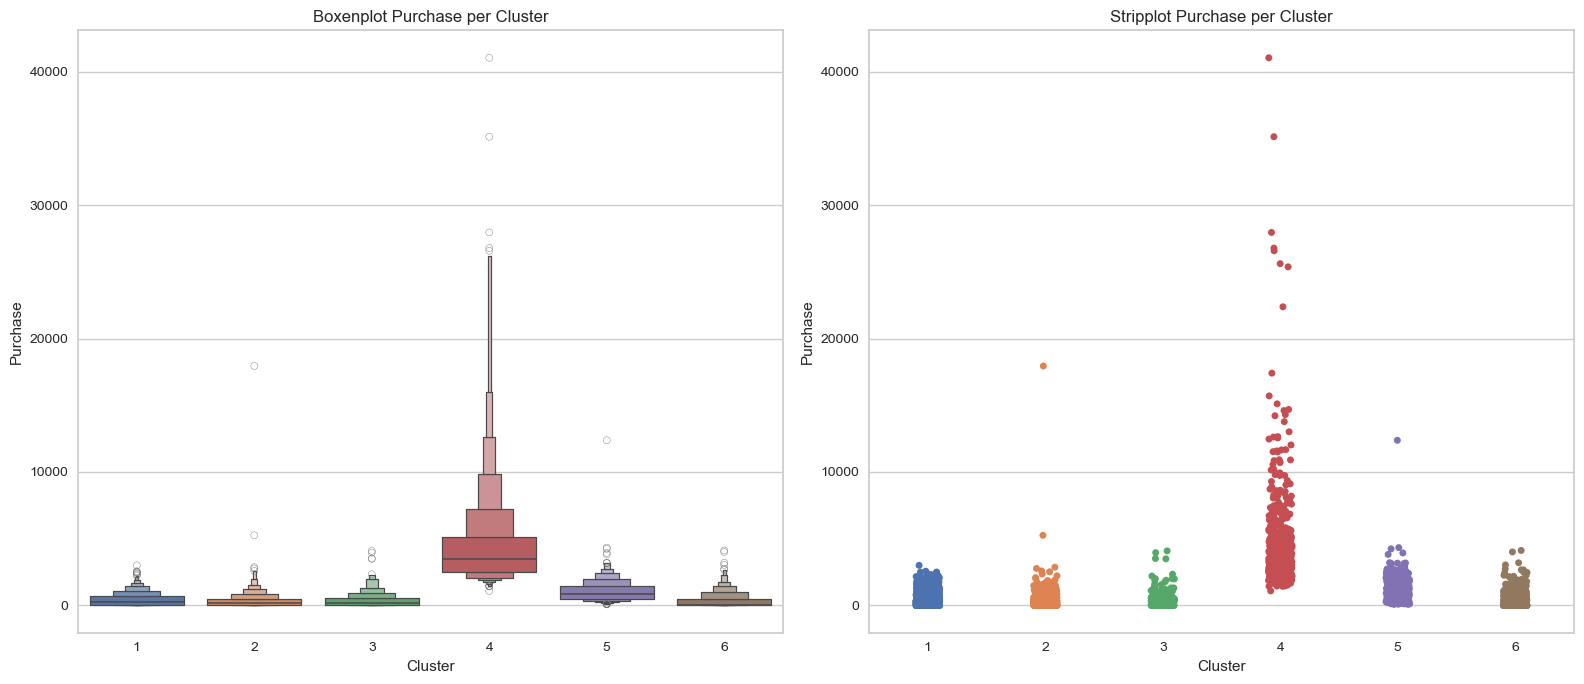

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='PURCHASES', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Purchase per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Purchase')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='PURCHASES', ax=axs[1], palette='deep')
axs[1].set_title(f'Stripplot Purchase per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Purchase')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot, mayoritas nasabah dari cluster 4 memiliki nilai pembelian yang yang lebih tinggi dan range nilai yang lebih luas dibandingkan cluster lain. Lebih dari 75 % nasabahnya memiliki nilai transaksi di bawah 10 ribu, sedangkan sisanya memiliki nilai transaksi di atas 10000 hingga sekitar 25000. Data point cluster ini lebih tersebar dibandingkan cluster - cluster lain, hal ini mengindikasikan bahwa cluster 4 memiliki nilai purchase yang lebih bervariasi dibandingkan cluster lain dan mengindikasikan sifat nasabahnya yang kurang seragam dalam melakukan transaksi ini. Yang perlu dicatat, tidak ada nasabah dari cluster ini yang memiliki nilai pembelian sama dengan 0, sedangkan pada cluster menunjukan adanya nasabah yang memiliki nilai purchase sama dengan 0 (Nasabah belum melakukan transaksi)

2. Cluster 1, 2, 3, 5, dan 6 memiliki rentang nilai transaksi yang jauh lebih sempit dibandingkan cluster 4. Jika dilihat dari ketinggian box (Q1 dan Q3), maka kita dapat menyimpulkan bahwa mayoritas nilai purchasenya lebih kecil dibandingkan dengan nilai transaksi nasabah cluster 4. Ukuran box yang kecil mengindikasikan jika variasi nilai cluster 1, 2, 3, 5, dan 6 sangat kecil atau dapat dikatakan hampir seluruh nasabahnya memiliki karakter transaksi yang mirip dalam melakukan transaksi

#### Cluster berdasarkan One off Purchase

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\3362952704.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='ONEOFF_PURCHASES', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\3362952704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='ONEOFF_PURCHASES', ax=axs[1], palette='deep')


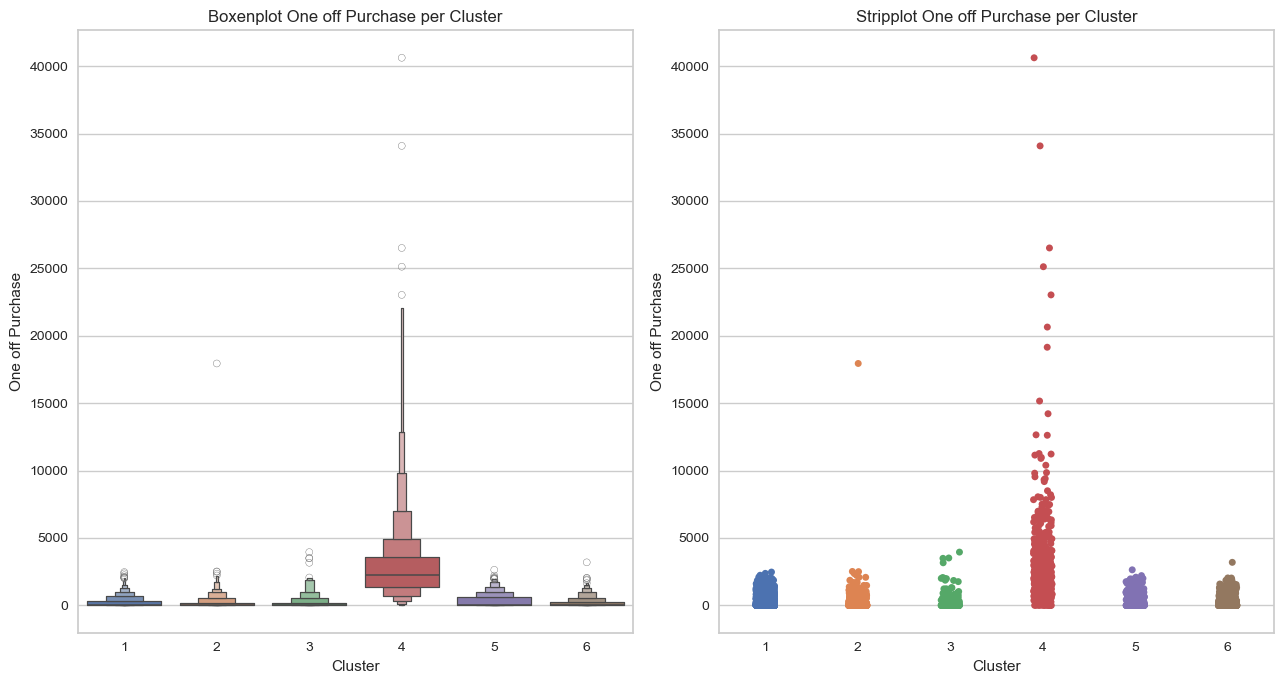

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='ONEOFF_PURCHASES', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot One off Purchase per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('One off Purchase')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='ONEOFF_PURCHASES', ax=axs[1], palette='deep')
axs[1].set_title(f'Stripplot One off Purchase per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('One off Purchase')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, mayoritas nasabah dari cluster 4 yang menggunakan one off purchase memiliki nilai pembelian yang lebih tinggi dan range nilai yang lebih luas dibandingkan cluster lain. Lebih dari 75 % nasabahnya memiliki nilai transaksi di bawah 5 ribu, sedangkan sisanya memiliki nilai pembelian di atas 5000 hingga sekitar 22000. Data point cluster ini lebih tersebar dibandingkan cluster - cluster lain, hal ini mengindikasikan bahwa cluster 4 memiliki nilai one off purchase yang lebih bervariasi dibandingkan cluster lain dan mengindikasikan sifat nasabahnya yang kurang seragam dalam melakukan transaksi ini

2. Cluster 1, 2, 3, 5, dan 6 memiliki rentang nilai transaksi yang jauh lebih sempit dibandingkan cluster 4. Jika dilihat dari ketinggian box (Q1 dan Q3), maka kita dapat menyimpulkan bahwa mayoritas nilai transaksinya lebih kecil dibandingkan dengan nilai transaksi nasabah cluster 4. Ukuran box yang kecil mengindikasikan jika variasi nilai cluster 1, 2, 3, 5, dan 6 sangat kecil atau dapat dikatakan hampir seluruh nasabahnya memiliki karakter transaksi yang mirip

#### Cluster berdasarkan Installments Purchase

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\3303445558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='INSTALLMENTS_PURCHASES', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\3303445558.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='INSTALLMENTS_PURCHASES', ax=axs[1], palette='deep')


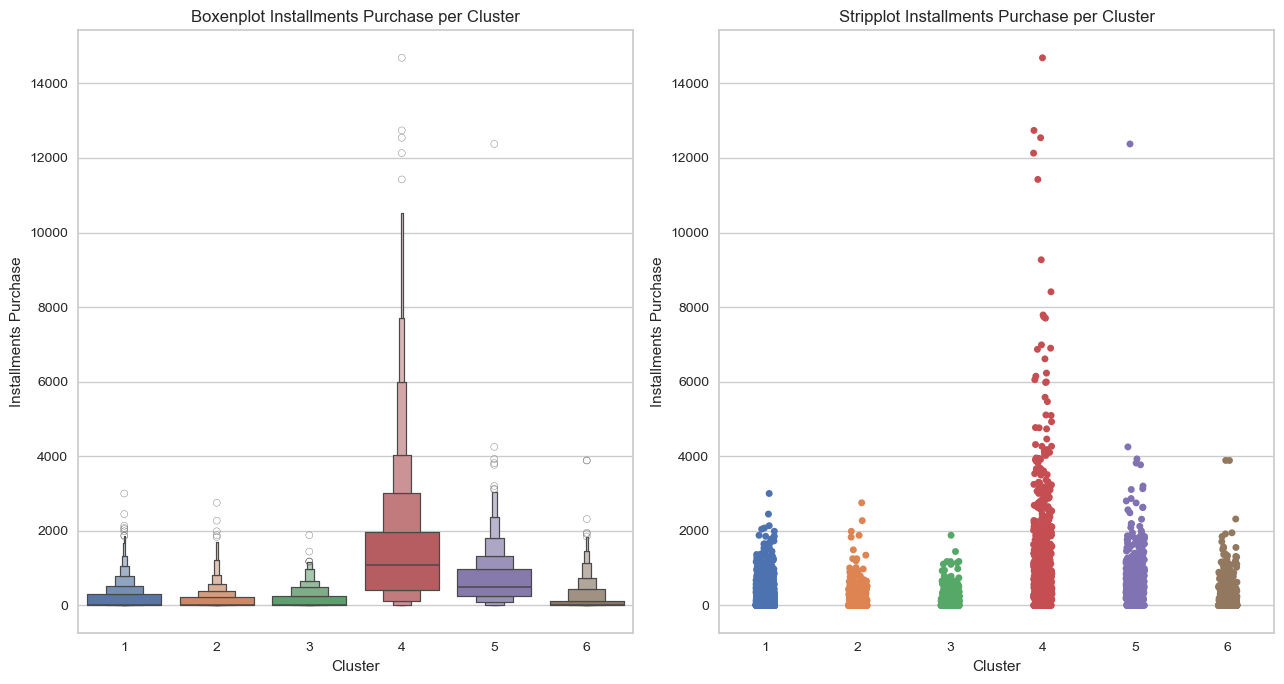

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='INSTALLMENTS_PURCHASES', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Installments Purchase per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Installments Purchase')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='INSTALLMENTS_PURCHASES', ax=axs[1], palette='deep')
axs[1].set_title(f'Stripplot Installments Purchase per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Installments Purchase')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, mayoritas nasabah dari cluster 4 yang melakukan installments purchase memiliki nilai transaksi yang lebih tinggi dan range nilai transaksi yang lebih luas dibandingkan cluster lain. Jika dilihat dari batas Q3, 75 % nasabahnya memiliki nilai transaksi di bawah atau sama dengan 2000, sedangkan sisanya memiliki nilai transaksi di atas 2000 hingga sekitar 11000. Data point cluster ini lebih tersebar dibandingkan cluster - cluster lain, hal ini mengindikasikan bahwa cluster 4 memiliki nilai installment purchase yang lebih bervariasi

2. Cluster 1, 2, 3, 5, dan 6 memiliki rentang nilai transaksi yang jauh lebih sempit dibandingkan cluster 4. Jika dilihat dari ketinggian box (Q1 dan Q3), maka kita dapat menyimpulkan bahwa mayoritas nasabah pada cluster - cluster tersebut nilai transaksinya lebih kecil dibandingkan nilai transaksi yang dihasilkan nasabah cluster 4

#### Cluster berdasarkan Cash Advance

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\608243117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='CASH_ADVANCE', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\608243117.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='CASH_ADVANCE', ax=axs[1], palette='deep')


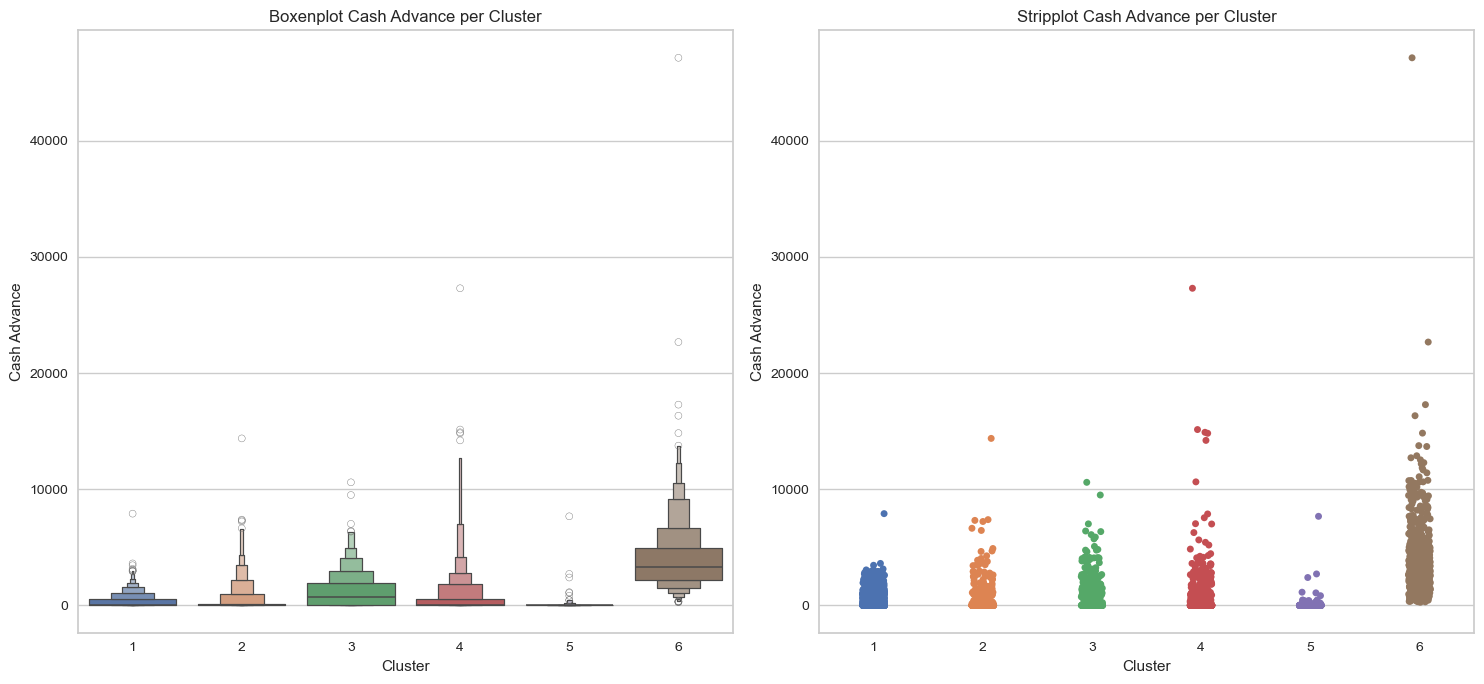

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='CASH_ADVANCE', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Cash Advance per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Cash Advance')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='CASH_ADVANCE', ax=axs[1], palette='deep')
axs[1].set_title(f'Stripplot Cash Advance per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Cash Advance')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, kita dapat mengambil kesimpulan bahwa mayoritas nasabah cluster 6 memiliki nilai transaksi cash advance yang lebih tinggi dibandingkan nilai transaksi cash advance yang dilakukan nasabah dari cluster lain (terutama cluster 5). Sebanyak 75 % lebih nasabah cluster 6 memiliki nilai transaksi cash advance di bawah 10000 dimana sisanya memiliki nilai transaksi di atas 10000 hingga 15000

2. Cluster 1, 2, 3, 4, dan 5 memiliki rentang nilai transaksi yang jauh lebih sempit dibandingkan cluster 6. Artinya, nilai transaksi cash advance dari cluster - cluster tersebut kurang bervariasi dibandingkan nilai transaksi dari cluster 6

3. Nasabah cluster 5 memiliki rentang nilai transaksi cash advance yang paling sempit dibandingkan nasabah dari cluster lain. Dari grafik di atas mengindikasikan jika hampir 100 % nasabah cluster 5 memiliki nilai cash advance hampir sebesar 0 atau dapat dikatakan sangat sedikit nasabah dari cluster ini yang melakukan transaksi cash advance

#### Cluster berdasarkan Credit Limit

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\29967527.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='CREDIT_LIMIT', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\29967527.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='CREDIT_LIMIT', ax=axs[1], palette='deep')


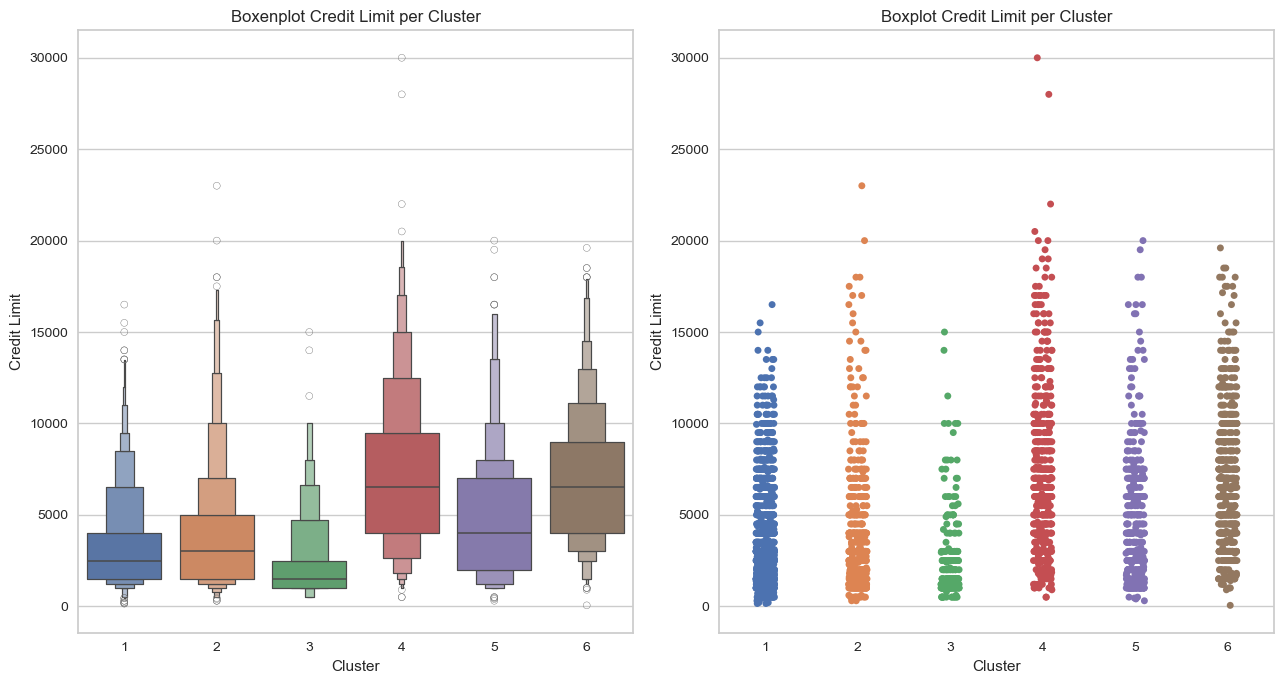

In [111]:
columns = ['PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT','TENURE','PRC_FULL_PAYMENT']

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='CREDIT_LIMIT', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Credit Limit per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Credit Limit')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='CREDIT_LIMIT', ax=axs[1], palette='deep')
axs[1].set_title(f'Boxplot Credit Limit per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Credit Limit')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, distribusi nilai credit limit dari cluster 4 dan 6 hampir identik atau dapat dikatakan mirip. Artinya, mayoritas nasabah dari cluster 4 dan cluster 6 memiliki kemiripan nilai dalam hal credit limit

2. Cluster 3 memiliki distribusi nilai credit limit yang paling sempit. Jika dilihar dari ketinggian box nya (Q1 sampai Q3) maka dapat diambil kesimpulan jika mayoritas nasabah cluster 3 memiliki nilai credit limit yang lebih rendah dibandingkan nilai kredit limit nasabah dari cluster - cluster lain

#### Cluster berdasarkan Tenure

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\781610256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='TENURE', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\781610256.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='TENURE', ax=axs[1], palette='deep')


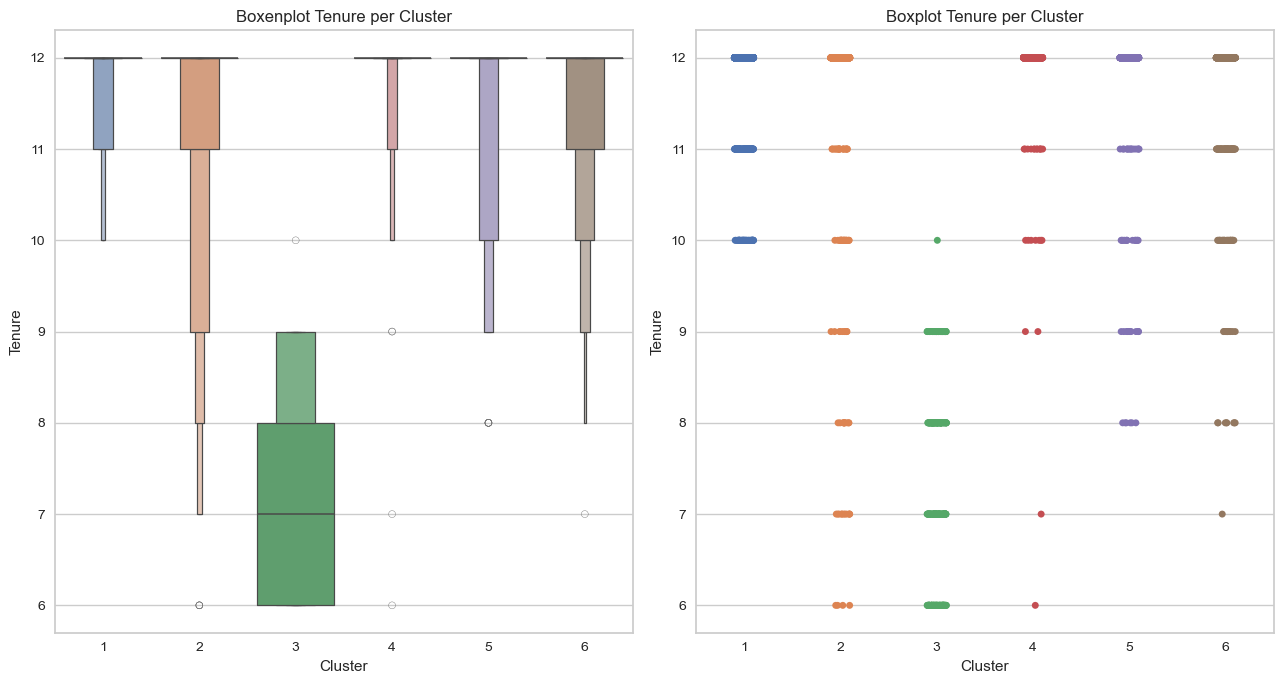

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='TENURE', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Tenure per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Tenure')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='TENURE', ax=axs[1], palette='deep')
axs[1].set_title(f'Boxplot Tenure per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Tenure')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, cluster 1, 2, 4, 5, dan 6 memiliki distribusi tenure yang lebih sempit dimana sebagian besar nasabah dari cluster - cluster tersebut memiliki tenure dalam rentang 10 hingga 12 bulan. Sempitnya distribusi mengindikasikan bahwa hanya ada sedikit variasi nilai tenure pada masing - masing cluster tersebut

2. Cluster 3 memiliki distribusi nilai yang lebih luas dibandingkan cluster lain dimana 75 % nasabahnya memiliki nilai tenure dalam rentang 6 sampai 8 bulan, sedangkan sisanya memiliki nilai tenure selama 9 bulan. Dapat disimpulkan jika mayoritas nasabah cluster 3 memiliki nilai tenure yang lebih rendah dibandingkan mayoritas nasabah cluster - cluster lain

#### Cluster berdasarkan Percent Of Full Payment

C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\2474280077.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=dfCl, x='Cluster', y='PRC_FULL_PAYMENT', ax=axs[0], palette='deep')
C:\Users\Fiqih\AppData\Local\Temp\ipykernel_13784\2474280077.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=dfCl, x='Cluster', y='PRC_FULL_PAYMENT', ax=axs[1], palette='deep')


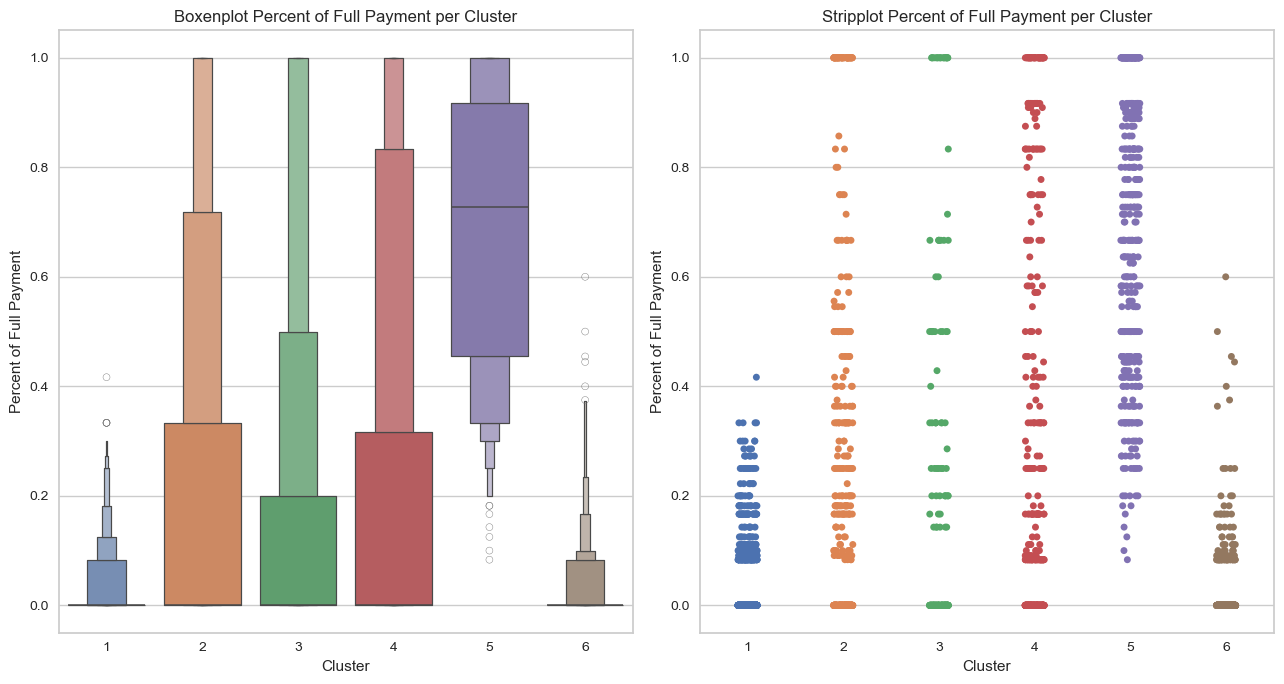

In [113]:
columns = ['PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT','TENURE','PRC_FULL_PAYMENT']

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
# Membuat boxenplot
sns.boxenplot(data=dfCl, x='Cluster', y='PRC_FULL_PAYMENT', ax=axs[0], palette='deep')
axs[0].set_title(f'Boxenplot Percent of Full Payment per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Percent of Full Payment')

# Membuat boxplot
sns.stripplot(data=dfCl, x='Cluster', y='PRC_FULL_PAYMENT', ax=axs[1], palette='deep')
axs[1].set_title(f'Stripplot Percent of Full Payment per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Percent of Full Payment')

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari grafik di atas kita dapat mengambil insight sebagai berikut :
1. Berdasarkan grafik boxenplot dan stripplot di atas, terlihat jika mayotiras nasabah cluster 5 memiliki memiliki nilai percent of full payment lebih dari 40 %. Hal ini mengindikasikan jika nasabah cluster 5 merupakan nasabah yang memiliki resiko gagal bayar paling kecil karena mayoritas nasabahnya memiliki nilai percent of payment yang lebih tinggi dibandingkan mayoritas nasabah dari cluster - cluster lain

2. 75% nasabah dari cluster 1, 2, 3, 4, dan 6 memiliki nilai percent of full payment dibawah 40 %. Rentang nilai percent of full payment terendah berasal dari nasabah cluster 1 dan 6 dimana 100 % nasabah dari kedua cluster tersebut (dengan mengabaikan outlier) memiliki rentang percent of fullpayment dibawah 40 %

#### Profiling

Profile customer akan memiliki beberapa komponen. Komponen tersebut diambil dari feature - feature tertentu. Tidak semua feature akan dimasukan sebagai komponen. Hanya feature - feature tertentu yang dianggap memiliki bobot besar dalam menjelaskan karakter nasabah saja yang akan dimasukan sebagai komponen. Berikut feature - featurenya :
1. Jumlah dan presentase nasabah
    Komponen ini ditujukan untuk mengetahui seberapa besar cluster dan efeknya terhadap feature lain. Sebagai contoh jika suatu cluster indentik dengan ketelatan pembayaran, maka kita dapat mengetahui seberapa besar dampak tersebut terhadap perusahaan jika dilihat dari jumlah nasabahnya
2. Nilai rata - rata dan jumlah transaksi cash advance
    Layanan cash advances memberikan nasabah kesempatan untuk meminjam uang tunai kepada kreditur menggunakan kartu kredit. Layanan ini memiliki resiko yang tinggi karena kreditur tidak memiliki kontrol untuk mengetahui untuk apa dan kapan uang tersebut dikembalikan. Cash advance menjadi sangat berbahaya jika digunakan oleh nasabah yang memiliki percent of full payment yang rendah. Karena efeknya yang besar jika digunakan pada nasabah yang salah, maka saya memasukan feature - feature yang berkaitan dengan cash advance kedalam komponen profile
3. Percent of full payment 
    Percent of full payment dapat diartikan sebagai presentase jumlah uang yang dikembalikan oleh nasabah terhadap total tagihan kartu kredit atau cash advance. Komponen ini sangat penting untuk mempelajari integritas dari seorang nasabah dan diharpkan dengan komponen ini perusahaan/bank dapat memberikan promosi atau layanan extra pada nasabah - nasabah yang berintegritas tinggi
4. Purchase dan purchase transactions
    2 komponen tersebut menjelaskan seberapa banyak uang yang dipinjam pada bank untuk membeli barang (menggunakan kartu kredit) dan seberapa banyak transaksinya. Komponen ini akan menjelaskan seberapa aktif suatu cluster dalam melakukan transaksi dengan kartu kredit dan seberapa besar uang yang dipinjam/nasabah kepada bank untuk membeli barang
5. Tenure
    Adalah jangka waktu angsuran yang harus diberikan pada perusahaan/bank. Komponen ini menjelaskan seberapa yakin seorang nasabah dalam melunasi tagihannya. Jika nasabah memiliki tenure yang rendah, maka artinya ansabah tersebut yakin dapat melunasi seluruh tagihan dalam waktu yang sebentar




1. Cluster 1
   - Memiliki jumlah nasabah terbanyak yaitu sebesar 1795 orang atau 41.6 % dari total nasabah
   - Nilai rata - rata cash advance tergolong sedang yaitu sebesar 375.16 dengan rata - rata jumlah transaksi sebanyak 2 kali/nasabah
   - Tergolong cluster dengan nasabah yang memiliki resiko yang sangat besar untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya hanya 2 persen dan lebih dari 75 % nasabahnya memiliki nilai percent full of payment dibawah 20 %
   - Tergolong cluster dengan nasabah yang cukup aktif dalam melakukan pembelian barang dengan dengan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 8 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 429.3/nasabah
   - Seluruh nasbah pada customer ini memiliki rentang tenure 10 - 12 bulan

2. Cluster 2
   - Cluster urutan ke 4 berdasarkan jumlah nasabahnya (13 % dari total keseluruhan nasabah)
   - Nilai rata - rata cash advance tergolong sedang yaitu sbesar 419.68 dengan rata - rata jumlah transaksi yang sangat sedikit yaitu sebanyak 1 kali/nasabah
   - Tergolong cluster dengan nasabah yang memiliki resiko cukup besar untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya sebesar 23 persen dan lebih 75 % nasabahnya memiliki rentang nilai percent full payment 0 - 35 %
   - Tergolong cluster dengan nasabah yang tidak cukup aktif dalam melakukan pembelian barang dengan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 5 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 383.9/nasabah
   - 75 % nasabah pada cluster ini memiliki rentang tenure 11 - 12 bulan

3. Cluster 3
   - Cluster dengan jumlah nasabah paling sedikit yaitu sebesar 269 orang atau 6.2 % dari total nasabah
   - Nilai rata - rata cash advance tergolong cukup tinggi yaitu sbesar 1249.94 dengan rata - rata jumlah transaksi sebanyak 3 kali/nasabah
   - Tergolong cluster dengan nasabah yang memiliki resiko cukup besar untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya sebesar 15 % persen dan 75 % nasabahnya memiliki nilai percent full paymentnya lebih rendah atau sama dengan 20 %
   - Tergolong cluster dengan nasabah yang tidak cukup aktif dalam melakukan pembelian barang menggunakan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 5 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 399.9/nasabah
   - 75 % nasabah pada cluster ini memiliki rentang tenure 6 - 8 bulan

4. Cluster 4
   - Cluster urutan ke 3 berdasarkan jumlah nasabah (13.1 % dari total keseluruhan nasabah)
   - Nilai rata - rata cash advance tergolong sedang yaitu sbesar 714.71 dengan rata - rata jumlah transaksi sebanyak 2 kali/nasabah
   - Tergolong cluster dengan nasabah yang memiliki resiko cukup besar untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya sebesar 22 % persen dan 75 % nasabahnya memiliki nilai lebih rendah atau sama dengan 30 %
   - Tergolong cluster dengan nasabah yang sangat aktif dalam melakukan pembelian barang menggunakan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 58 kali/nasabah
   - Cluster ini memiliki nilai rata - rata purchase tertinggi dengan nilai sebesar 4578.03/nasabah dan memiliki rentang nilai purchase terluas dimana nilai minimumnya sebesar 0 dan nilai maksimumnya sebesar 22000 (variasi tinggi)
   - 75 % nasabah pada cluster ini memiliki rentang tenure 11 - 12 bulan

5. Cluster 5
   - Cluster urutan ke 5 berdasarkan jumlah nasabah (10.9 % dari total keseluruhan nasabah)
   - Cluster ini memiliki nilai rata - rata cash advance yang paling kecil yaitu sbesar 42.9 dengan rata - rata jumlah transaksi mendekati 0 
   - Tergolong cluster dengan nasabah yang memiliki resiko yang sangat kecil untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya sebesar 68 % persen dan seluruh nasabahnya memiliki rentang nilai 20 % - 100 %. Cluster ini menjadi satu - satunya cluster yang tidak memiliki nasabah dengan dengan nilai percent full payment 0 %
   - Tergolong cluster dengan nasabah yang cukup aktif dalam melakukan pembelian barang menggunakan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 19 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 1076.18/nasabah
   - 75 % nasabah pada cluster ini memiliki rentang tenure 9 - 12 bulan

6. Cluster 6
   - Cluster urutan ke 2 berdasarkan jumlah nasabah (15.3 % dari total keseluruhan nasabah)
   - Cluster ini memiliki nilai rata - rata cash advance yang paling besar yaitu sebesar 4024/nasabah dengan rata - rata jumlah transaksi sebanyak 13 kali/nasabah (terbesar)
   - Cluster dengan nasabah yang memiliki resiko terbesar untuk mendapatkan status gagal bayar karena nilai rata - rata percent of full paymentnya hanya sebesar 2 % persen dan 75 % nasabahnya memiliki nilai percent of full payment dibawah 20%
   - Tergolong cluster dengan keaktifan nasabah yang sedang dalam melakukan pembelian barang menggunakan kartu kredit dimana rata - rata jumlah transaksinya (purchase transactions) sebanyak 7 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 359.19/nasabah
   - 75 % nasabah pada cluster ini memiliki rentang tenure 11 - 12 bulan


Catatan :

   Penggolongan status resiko gagal didasarkan atas asmumsi :
   - Resiko gagal baya tinggi    : Nilai rata - rata percent of full payment di bawah 40 %
   - Resiko gagal bayar sedang   : Nilai rata - rata percent of full payment di antara 40 % - 60 %
   - Resiko gagal bayar kecil    : Nilai rata - rata percent of full payment lebih dari 60 %

# 10. Model saving

In [114]:
#Model saving
with open('scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)

with open('model.pkl', 'wb') as file_2:
  pickle.dump(kmFinal, file_2)

with open('pca.pkl', 'wb') as file_3:
  pickle.dump(pca2, file_3)

with open('list_cols.txt', 'w') as file_4:
  json.dump(selectedCol, file_4)

# 11. Model inference

In [115]:
# Load model and other files

with open('scaler.pkl', 'rb') as file_1:
  scaler = pickle.load(file_1)

with open("model.pkl", "rb") as file_2:
  model = pickle.load(file_2)

with open("pca.pkl", "rb") as file_3:
  pcaInf = pickle.load(file_3)

with open('list_cols.txt', 'r') as file_4:
  list_cols = json.load(file_4)

In [116]:
# Membuat data dummy
data_dummy = {
    'CUST_ID': [8933, 7675, 3821, 8124],
    'BALANCE' : [0,1243.2,704,4500],
    'BALANCE_FREQUENCY' : [1,0.88,0.9,0],
    'PURCHASES' : [600,2000,7000,500],
    'ONEOFF_PURCHASES' : [300,1000,3500,250],
    'INSTALLMENTS_PURCHASES': [300, 1000, 3500, 250],
    'CASH_ADVANCE': [241, 3009, 1500, 755],
    'PURCHASES_FREQUENCY': [0.27, 0.58, 0.72, 1],
    'ONEOFF_PURCHASES_FREQUENCY': [1, 0.77, 1, 0],
    'PURCHASES_INSTALLMENTS_FREQUENCY': [0.65, 1, 0, 0.98],
    'CASH_ADVANCE_FREQUENCY': [1, 0, 0.42, 0.58],
    'CASH_ADVANCE_TRX': [1, 7, 10, 4],
    'PURCHASES_TRX': [22, 5, 44, 6],
    'CREDIT_LIMIT': [8000, 4000, 23000, 4500],
    'PAYMENTS': [1808, 1100, 430, 243],
    'MINIMUM_PAYMENTS': [2100, 410, 230, 450],
    'PRC_FULL_PAYMENT': [0.18, 0.22, 0.46, 0.6],
    'TENURE': [12, 12, 6, 10]
}

# Create DataFrame
df_data_dummy = pd.DataFrame(data_dummy)

# Display DataFrame
df_data_dummy.head()

CUST_ID  BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     8933      0.0               1.00        600               300   
1     7675   1243.2               0.88       2000              1000   
2     3821    704.0               0.90       7000              3500   
3     8124   4500.0               0.00        500               250   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     300           241                 0.27   
1                    1000          3009                 0.58   
2                    3500          1500                 0.72   
3                     250           755                 1.00   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                        1.00                              0.65   
1                        0.77                              1.00   
2                        1.00                              0.00   
3                        0.00                              0.98   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    1.00                 1             22          8000   
1                    0.00                 7              5          4000   
2                    0.42                10             44         23000   
3                    0.58                 4              6          4500   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0      1808              2100              0.18      12  
1      1100               410              0.22      12  
2       430               230              0.46       6  
3       243               450              0.60      10

In [117]:
# Membuat dataframe baru
data_inference = df_data_dummy[list_cols]

# Proses scaling
diScaled = scaler.transform(data_inference)

# Membuat dataframe baru
diScaled = pd.DataFrame(diScaled,columns=list_cols)

# Dimensional reduction
scaledpca = pcaInf.transform(diScaled)

In [118]:
# Cek hasil
scaledpca

array([[-1.88258452, -0.23285514,  0.35115624, -0.01615726, -0.34045689,
        -0.37452334,  0.55029475, -1.49781486,  0.82969592, -0.98073257],
       [-0.86420908,  0.95870301,  1.29569125,  0.58334084, -0.49179663,
        -0.47197094, -0.98497952, -0.83830265, -0.47294032, -0.12305262],
       [-3.84170147,  6.27596433,  4.37590482,  5.90731257,  3.82251351,
         0.95958827, -1.17138395, -1.68982654, -2.45945664,  4.49913692],
       [ 8.04258661,  1.29597247,  5.52829279,  1.58111536, -0.54460178,
         1.35798211,  1.10711743, -2.35321361, -0.2061847 ,  0.48028357]])

In [119]:
# Proses clustering
predInf = model.predict(scaledpca)

In [120]:
# Cek hasil
predInf

array([0, 0, 3, 1])

In [121]:
# Buat kolom cluster
df_data_dummy['Cluster'] = predInf

# Mengganti nilai pada kolom Cluster
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(0,10)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(1,11)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(2,12)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(3,13)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(4,14)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(5,15)

# Mengganti nilai pada kolom Cluster
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(10,1)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(11,2)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(12,3)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(13,4)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(14,5)
df_data_dummy['Cluster'] = df_data_dummy['Cluster'].replace(15,6)

# Cek hasil
df_data_dummy

CUST_ID  BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     8933      0.0               1.00        600               300   
1     7675   1243.2               0.88       2000              1000   
2     3821    704.0               0.90       7000              3500   
3     8124   4500.0               0.00        500               250   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     300           241                 0.27   
1                    1000          3009                 0.58   
2                    3500          1500                 0.72   
3                     250           755                 1.00   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                        1.00                              0.65   
1                        0.77                              1.00   
2                        1.00                              0.00   
3                        0.00                              0.98   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    1.00                 1             22          8000   
1                    0.00                 7              5          4000   
2                    0.42                10             44         23000   
3                    0.58                 4              6          4500   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  Cluster  
0      1808              2100              0.18      12        1  
1      1100               410              0.22      12        1  
2       430               230              0.46       6        4  
3       243               450              0.60      10        2

Dari hasil di atas, maka dapat ditarik informasi sebagai berikut :

1. Customer ID 8933 masuk dalam cluster 1
2. Customer ID 7675 masuk dalam cluster 1
3. Customer ID 3821 masuk dalam cluster 4
3. Customer ID 8124 masuk dalam cluster 2

# 12. Kesimpulan

### EDA
1. Sebanyak 93 % nasabah kartu kredit memiliki nilai balance kurang dari 5000 dan hanya 0.97 % nasabah kartu kredit yang memiliki nilai balance sebesar 0 (nilai transaksi = kredit limit). Selain itu, terdapat 7 % nasabah yang memiliki nilai balance dalam rentang 5000 hingga 18250
2. Sebanyak 97 % nasabah kartu kredit memiliki kredit limit kurang dari 14000, sedangkan 3 % nya memilki kredit limi dalam rentang 14000 hingga 30000
3. Mayoritas nasabah pemegang kartu kredit (84.4 %) memiliki tenure selama 12 bulan
4. Dalam 6 bulan terakhir, mayoritas nasabah melakukan transaksi dengan rentang jumlah 0 - 45 kali. Sebagian kecil nasabah melakukan transaksi dalam rentang 46 - 350 kali dalam 6 bulan terakhir
5. Nilai limit kredit akan cenderung meningkat jika lama waktu tenure juga meningkat

### Model evaluation
1. Informasi yang dipertahankan dalam pengurangan dimensi feature adalah sebesar 95 % dengan jumlah dimensi final sebesar 10. Keputusan untuk mempertahankan 95 % informasi didasarkan pada alasan agar hasil clustering dapat mewakili data seaktual mungkin dan tidak menghilangkan informasi - informasi dari feature - feature yang memiliki nilai - nilai ekstrim. Seperti yang kita tahu pada proses outliers handling, 13 dari 17 feature memiliki presentase outlier di atas 8 %. Untuk mengantisipasi jika suatu saat model harus melakukan prediksi pada dataset yang memiliki banyak outlier, maka saya putuskan 95 % informasi dipertahankan agar model terbiasa dalam menghandle dataset seperti ini

2. Bedasarkan metode elbow dan sillhouette scoring, nilai K optimal yang dipilih adalah 6. Berdasarkan metode elbow, nilai 6 dipilih karena penurunan inertia yang tidak terlalu signifikan atau slope tidak terlalu curam ketika jumlah cluster dirubah dari 6 ke 7. Berdasarkan metode sillhouette score, nilai K = 6 dipilih karena nilai tersebut memberikan distribusi datapoint yang paling balance dibandingkan nilai K lain. Selain itu, nilai rata - rata sillhouette scorenya tidak terlalu kecil dibandingkan dengan nilai score dari nilai K lain

3. Berdasarkan tes sillhouette score, semua nilai K yang ditrial menghasilkan nilai rata - rata score dibawah 0.4. Hal ini mengindikasikan jika proses clustering belum optimal karena nilai rata - rata score yang kecil memiliki arti bahwa data point tidak terlalu cocok dengan clusternya sendiri. Kemungkinan besar penyebab kenapa semua nilai score yang didapatkan kecil karena terdapat outlier dalam jumlah yang banyak. Outlier memiliki jarak ke data point tetangga (1 cluster) yang cukup jauh sehingga pembagi pada rumus silhouette score akan relatif menjadi besar. Hasilnya, nilai rata - rata sillhouette score akan semakin kecil

4. Dari hasil clustering, didapatkan populasi masing - masing cluster sebagai berikut :
   1. Cluster 1     : 1795 orang (41.6 %)
   2. Cluster 2     : 560 orang (13 %)
   3. Cluster 3     : 269 orang (6.2 %)
   4. Cluster 4     : 567 orang (13.61 %)
   5. Cluster 5     : 469 orang (10.9 %)
   6. Cluster 6     : 660 orang (15.3 %)

5. Berikut adalah profil dari 6 cluster hasil profiling :
   - Cluster 1
     1. ***Memiliki jumlah nasabah terbanyak (41.6 %)***
     2. Nilai rata - rata cash advance tergolong sedang (375.16) dengan rata - rata transaksi cash advance yang tergolong sedikit (2 kali/nasabah)
     3. ***Memiliki resiko gagal bayar yang sangat besar dengan nilai rata - rata percent of full payment sebesar 2% dan lebih dari 75 % nasabahnya memiliki nilai percent of full payment di bawah 20 % dalam 6 bulan kebelakang***
     4. Cukup aktif dalam melakukan transaksi dengan rata - rata transaksi 8 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 429.3/nasabah
     5. Rentang tenure 10 - 12 bulan

   - Cluster 2
     1. Memiliki nasabah sebanyak 13 % dari total keseluruhan nasabah
     2. ***Nilai rata - rata cash advance tergolong cukup besar (419.68) dengan rata - rata jumlah transaksi cash advance yang relatif kecil (1 kali/nasabah)***
     3. ***Memiliki resiko gagal bayar yang cukup besar*** dengan rata - rata percent of full payment sebesar 23 % dalam 6 bulan terakhir
     4. ***Tidak terlalu aktif dalam melakukan pembelian barang menggunakan kartu kredit*** dengan rata - rata transaksi sebesar 5 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 383.9/nasabah
     5. 75 % nasabah memiliki rentang tenure 11 - 12 bulan

   - Cluster 3
     1. Memiliki nasabah sebanyak 6.2 % dari total keseluruhan nasabah 
     2. ***Nilai rata - rata cash advance tergolong besar (1249.94/nasabah)*** dengan rata - rata jumlah transaksi cash advance yang relatif kecil (3 kali/nasabah)
     3. ***Memiliki resiko gagal bayar yang besar*** dengan rata - rata percent of full payment sebesar 15 % dalam 6 bulan terakhir 
     4. ***Tidak terlalu aktif dalam melakukan pembelian barang menggunakan kartu kredit*** dengan rata - rata transaksi sebesar 5 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 399.9/nasabah
     5. 75 % nasabah memiliki rentang tenure 6 - 8 bulan

   - Cluster 4
     1. Memiliki nasabah sebanyak 13.1 % dari total keseluruhan nasabah
     2.***Nilai rata - rata cash advance tergolong sedang*** (714.71) dengan ***rata - rata jumlah transaksi cash advance yang relatif kecil (2 kali/nasabah)***
     3. ***Memiliki resiko gagal bayar yang cukup besar*** dengan rata - rata percent of full payment sebesar 15 % dalam 6 bulan terakhir 
     4. ***Cluster dengan nasabah paling aktif dalam melakukan pembelian barang menggunakan kartu kredit dengan rata - rata transaksi sebesar 58 kali/nasabah***
     5. ***Memiliki nilai rata - rata purchase tertinggi (4578.03/nasabah) dengan rentang nilai purchase yang terluas (0 - 22000)***
     6. 75 % nasabah memiliki rentang tenure 11 - 12 bulan
    
   - Cluster 5
     1. Memiliki nasabah sebanyak 10.9 % dari total keseluruhan nasabah
     2. ***Nilai rata - rata cash advance yang sangat kecil (42.9/nasabah) dengan rata - rata jumlah transaksi cash advance yang mendekati 0/nasabah***
     3. ***Memiliki resiko gagal bayar yang sangat kecil dengan rata - rata percent of full payment sebesar 68 % dalam 6 bulan terakhir*** 
     4. ***Cluster dengan nasabah cukup aktif dalam melakukan pembelian barang menggunakan kartu kredit dengan rata - rata transaksi sebesar 19 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 1076.18/nasabah***
     5. 75 % nasabah memiliki rentang tenure 9 - 12 bulan

   - Cluster 6
     1. Memiliki nasabah sebanyak 15.3 % dari total keseluruhan nasabah
     2. ***Cluster dengan nilai rata - rata cash advance yang paling besar (42024/nasabah) dengan rata - rata jumlah transaksi cash advance sebanyak 13 kali/nasabah***
     3. ***Clister yang memiliki resiko gagal bayar terbesar dengan rata - rata percent of full payment sebesar 2 % dalam 6 bulan terakhir*** 
     4. ***Cluster dengan nasabah yang tidak terlalu aktif dalam melakukan pembelian barang menggunakan kartu kredit*** dengan rata - rata transaksi sebesar 7 kali/nasabah dan rata - rata nominal yang ditransaksikan sebesar 359.19/nasabah
     5. 75 % nasabah memiliki rentang tenure 11 - 12 bulan

6. Berikut adalah beberapa saran untuk pemberi kredit berdasarkan profile masing - masing cluster :
    1.  Berikan penalty terhadap nasabah - nasabah dari cluster yang memiliki nilai rata - rata percent of full payment < 40 %. Tujuannya agar mengurangi jumlah nasabah yang memiliki resiko besar gagal bayar. Penalti dapat dilakukan dengan cara peningkatan denda keterlambatan, pengurangan tenure untuk transaksi kredit selanjutnya, atau pengurangan limit cash advance. Dengan dilakukannya hal tersebut diharapkan pemegang kartu kredit menjadi lebih bertanggung jawab dalam melakukan pelunasan tagihan

    2. Promosi layanan kartu kredit dan cash advance perlu ditingkatkan dan dimasifkan pada nasabah - nasabah yang berasal dari cluster 5 karena nasabah tersebut memiliki percent of full payment yang paling tinggi, nilai rata - rata pruchase yang besar, dan memiliki rata - rata jumlah transaksi cash advance yang paling rendah (hampir 0)

    3. Kurangi credit limit pada nasabah dari cluster 6 karena nilai rata - rata percent of full paymentnya sangat rendah (2% dalam 6 bulan). Permasalahan utamanya adalah, selain karena nilai rata - rata percent of payment nya yang rendah, mayoritas nasabah dari cluster ini menggunakan layanan kredit yang cukup riskan yaitu layanan cash advance (peminjaman uang secara tunai dengan kartu kredit) dimana perusahaan tidak memiliki kemampuan untuk mengetahui untuk apa uang tersebut digunakan dan kapan uang itu akan dikembalikan


### Model improvement
Berikut adalah beberapa saran untuk perbaikan model di masa depan :
1. Menghapus outlier sebagai salah satu opsi trial dalam memilih nilai K optimal
2. Tingkatkan max iteration untuk memastikan model mencapai titik konvergen dalam menentukan centroid
3. Mencoba model clustering yang lebih robust terhadap outlier seperti DBSCAN